## Cardio Catch DIseases

**Cardio Catch Diseases(CCD)** is the main cause of death in the world, responsible for 17 million deaths in 2017. These **CCD** are a group of diseases that affect the heart and the main blood vessels of the body. The main diseases are:

### Coronary Heart Disease

**Coronary Heart Diseases** occurs when the flow of oxygenated blood to the heart is blocked or reduced. They are: Angina, Heart Attacks and Heart Failure.

### Strokes and TIAs

**Stroke** occurs when part of the brain's blood supply is interrupted, causing brain damage or even death. **Transient Ischaemic Attack(TIA)** is the same interruption, but only temporary.

### Peripheral Arterial Disease

**Peripheral Arterial Disease** occurs when there is a blockage in the limbs arteries.

### Aortic Disease

They are a group of conditions that affect the aorta, which is responsible for carrying blood from the heart to the rest of the body. one of the main aortic disease is the aneurysm.

## Risk Factors
Some of the main risk factors for heart disease are high blood pressure, obesity, high cholesterol levels, diabetes, physical inactivity, alcohol, cigarettes, cases in the family, age, among others.

|Description | Feature Type | Feature | Data Type |
|---|---|---|---|
|Age | Objective Feature | age | int (days)|
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Gender | Objective Feature | gender | categorical code |
|Systolic blood pressure | Examination Feature | ap_hi | int |
|Diastolic blood pressure | Examination Feature | ap_lo | int |
|Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
|Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alco | binary |
|Physical activity | Subjective Feature | active | binary |
|Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

for binary data:
1: Positive/ 0: Negative

# 1.0. IMPORTS

In [1]:
import pandas        as pd
import numpy         as np
import statistics
import math

from scipy import stats       as ss

import matplotlib.gridspec    as gs
import matplotlib.pyplot      as plt
import seaborn                as sns

from boruta import BorutaPy

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, plot_precision_recall_curve, accuracy_score, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb

from scikitplot              import metrics      as mt

import xgboost as xgb

from IPython.display import Image

## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    
    sns.set()
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1)))
    
    
def stats_num_describe(num_attributes): # Statistical description of numeric values
    stats = num_attributes.describe().T

    stats['range'] = num_attributes.apply(lambda x: x.max() - x.min()) # add range to describe
    stats['skew'] = num_attributes.apply( lambda x: x.skew()) # add skew to describe
    stats['kurtosis'] = num_attributes.apply( lambda x: x.kurtosis()) # add kurtosis to describe
    
    return stats


def stats_cat_describe(cat_attributes): # Satistical description of categorical values
    values = pd.DataFrame(cat_attributes.apply(lambda x: x.value_counts())).T # creating counter of each catgorical value
    count = pd.DataFrame(cat_attributes.apply(lambda x: len(x))) # creating a count of all values
    mode = pd.DataFrame(cat_attributes.apply(lambda x: statistics.mode(x))) # creating a mode of the values

    stats = pd.concat([count, mode, values], axis=1) # concat

    list_columns = ['count', 'value_mode', 'value_0', 'value_1', 'value_2', 'value_3'] # rename columns
    stats.columns = list_columns # rename columns
    
    return stats 

In [3]:
jupyter_settings()

## 1.2. Import Data

In [4]:
df1 = pd.read_csv('data/cardio_train.csv', sep=';')
df1 = df1.drop('id', axis=1)

In [5]:
df1.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# 2.0. DATA DESCRIPTION

In [6]:
df2 = df1.copy()

## 2.1. Data Dimension

In [7]:
print('Number of rows: {}'.format(df2.shape[0]))
print('Number of columns: {}'.format(df2.shape[1]))

Number of rows: 70000
Number of columns: 12


## 2.2. Changings

In [8]:
# Changing the name of columns ap_hi, ap_lo, gluc and alco
df2.rename({'ap_hi': 'p_systolic', 'ap_lo': 'p_diastolic', 'gluc': 'glucose', 'alco': 'alcohol'}, axis=1, inplace=True)

In [9]:
# Changing Age Scale of days to years (rounding)
df2['age'] = round(df2['age']/365).astype(int) #rounding age

## 2.2. Data Types

In [10]:
df2.dtypes # discovering the dtypes

age              int64
gender           int64
height           int64
weight         float64
p_systolic       int64
p_diastolic      int64
cholesterol      int64
glucose          int64
smoke            int64
alcohol          int64
active           int64
cardio           int64
dtype: object

All dtypes ok

## 2.3. Check NA

In [11]:
df2.isna().sum() # checking missing values

age            0
gender         0
height         0
weight         0
p_systolic     0
p_diastolic    0
cholesterol    0
glucose        0
smoke          0
alcohol        0
active         0
cardio         0
dtype: int64

The data no have missing Data

## 2.4. Statistical Description - With Outliers

In [12]:
# dataframe numerical attributes
num_attributes = df2[['age', 'height', 'weight', 'p_systolic', 'p_diastolic']] 

# dataframe categorical attributes
cat_attributes = df2[['gender', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cardio']]

In [13]:
stats_num_describe(num_attributes)

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
age,70000.0,53.338686,6.765294,30.0,48.0,54.0,58.0,65.0,35.0,-0.306444,-0.821815
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0,195.0,-0.642187,7.943653
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0,190.0,1.012070,2.586825
p_systolic,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0,16170.0,85.296214,7580.074738
p_diastolic,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0,11070.0,32.114083,1425.914585


Num Attributes - values out of reality:
* Min height = 55?
* Max height = 250?
* Min weight = 10?
* Max p_systolic = 16020?
* Min p_systolic = -150?
* Max p_diastolic = 11000?
* Min p_diastolic = -70?

In [14]:
stats_cat_describe(cat_attributes)

,count,value_mode,value_0,value_1,value_2,value_3
gender,70000,1,NaN,45530.0,24470.0,NaN
cholesterol,70000,1,NaN,52385.0,9549.0,8066.0
glucose,70000,1,NaN,59479.0,5190.0,5331.0
smoke,70000,0,63831.0,6169.0,NaN,NaN
alcohol,70000,0,66236.0,3764.0,NaN,NaN
active,70000,1,13739.0,56261.0,NaN,NaN
cardio,70000,0,35021.0,34979.0,NaN,NaN


In [15]:
# printing the proportion of the response variable
print(df2['cardio'].value_counts(normalize=True)) # checking the proportion between the values of the response variable

0    0.5003
1    0.4997
Name: cardio, dtype: float64


* 50% to the each response
* The values of the response variable are balanced

# 3.0. FEATURE ENGINEERING

In [16]:
df3 = df2.copy()

## 3.1. Hypothesis MindMap

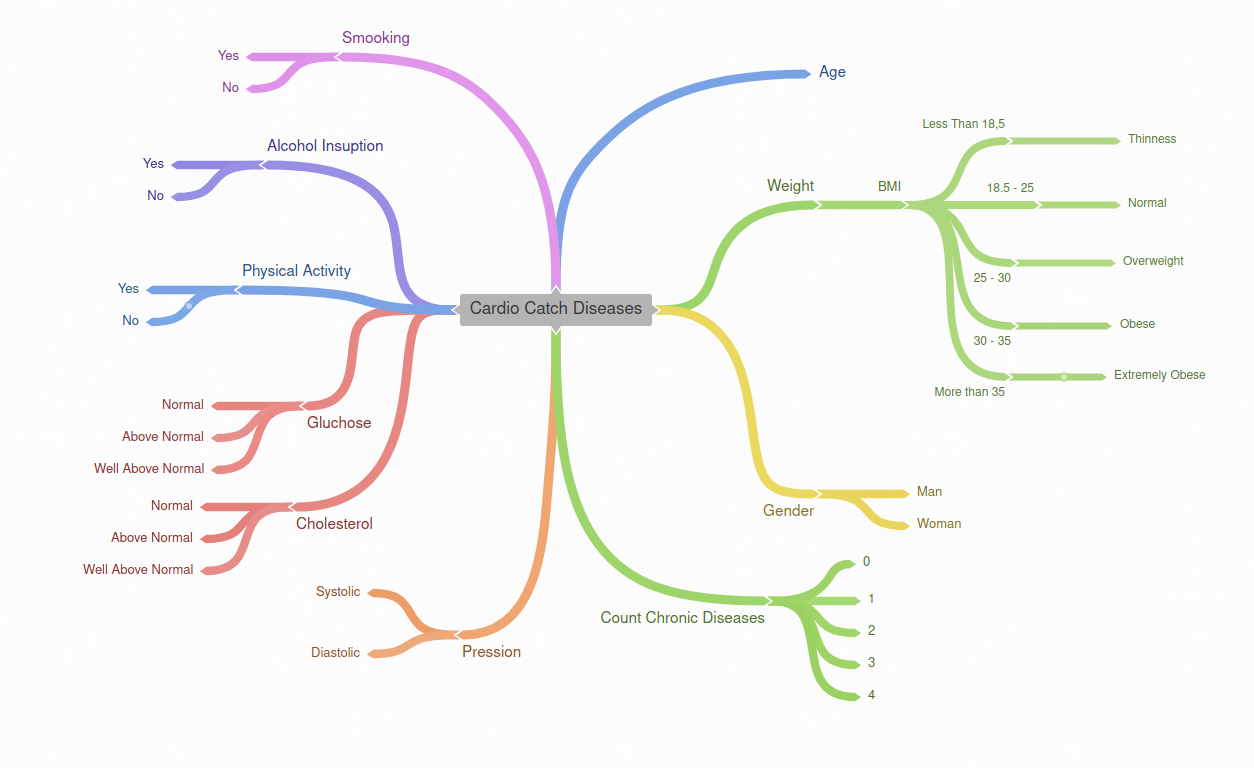

In [17]:
Image('img/MindMapHypothesis.png')

## 3.2. Hypothesis Creation

**1.** People with high BMI are more likely to have cardiovascular diseases;

**2.** Older people are more likely to have cardiovascular diseases;

**3.** Gender does not influence people's chances of having cardiovascular diseases;

**4.** Older people are more likely to have more cardiovascular diseases than young people with obesity;

**5.** People with more chronic diseases are more likely to have cardiovascular diseases;

**6.** People with high cholesterol are more likely to have cardiovascular diseases 

**7.** People with high glucose are more likely to have cardiovascular diseases

**8.** People who practice physical activities are least likely to have cardiovascular diseases 

**9.** People who smoke are more likely to have cardiovascular diseases

**10.** People who consume alcohol are more likely to have cardiovascular diseases

**11.** People with high systolic pressure are more likely to have cardiovascular diseases

**12.**  People with high diastolic pressure are more likely to have cardiovascular diseases

**13.** People with greater difference between systolic and diastolic pressures are more likely to have cardiovascular diseases

**14.** People classified as having high blood pressure are more likely to have cardiovascular diseases

## 3.3. Feature Engineering

### 3.3.1. New Features

In [18]:
# BMI
df3['bmi'] = df3['weight'] / (df3['height']/100)**2


# cat_bmi
df3['cat_bmi'] = df3['bmi'].apply(lambda x: 'thiness' if x < 18.5 else 'normal' if (18.5 <= x < 25)
                                  else 'overwight' if (25 <= x < 30 ) else 'obese' if (30 <= x < 35)
                                  else 'extremely obese')

# high_pressure
df3['high_pressure'] = df3.apply( lambda x: 1 if (x['p_systolic'] >= 140 or x['p_diastolic'] >= 90) else 0, axis=1)

# count_chronic_diseases
df3['is_o'] = df3['bmi'].apply(lambda x: 1 if x >= 30 else 0)
df3['is_d'] = df3['glucose'].apply(lambda x: 1 if (x==2 or x==3) else 0)
df3['high_c'] = df3['cholesterol'].apply(lambda x: 1 if (x==2 or x==3) else 0)

df3['count_chronic_diseases'] = df3['is_o'] + df3['is_d'] + df3['high_c'] + df3['high_pressure']

# dif_pression
df3['dif_pressure'] = df3['p_systolic'] - df3['p_diastolic']

# cat_age
df3['cat_age'] = df3['age'].apply(lambda x: '39 - 49' if x <= 49 else '50 - 59' if (50 <= x <= 59)
                                  else '60 - 65')

### 3.3.2. Categorical Data

In [19]:
# all_dataset
# gender
df3['gender'] = df3['gender'].map({1: 'man', 2: 'woman'})

# cholesterol
df3['cholesterol'] = df3['cholesterol'].map({1: 'normal', 2:'above_normal', 3:'well_above_normal'})

# glucose
df3['glucose'] = df3['glucose'].map({1: 'normal', 2:'above_normal', 3:'well_above_normal'})

# 4.0. FILTERING

In [20]:
df4 = df3.copy()

## 4.1. Filtering Rows

### 4.1.1. Height and Weight

Text(0.5, 1.0, 'Density weight')

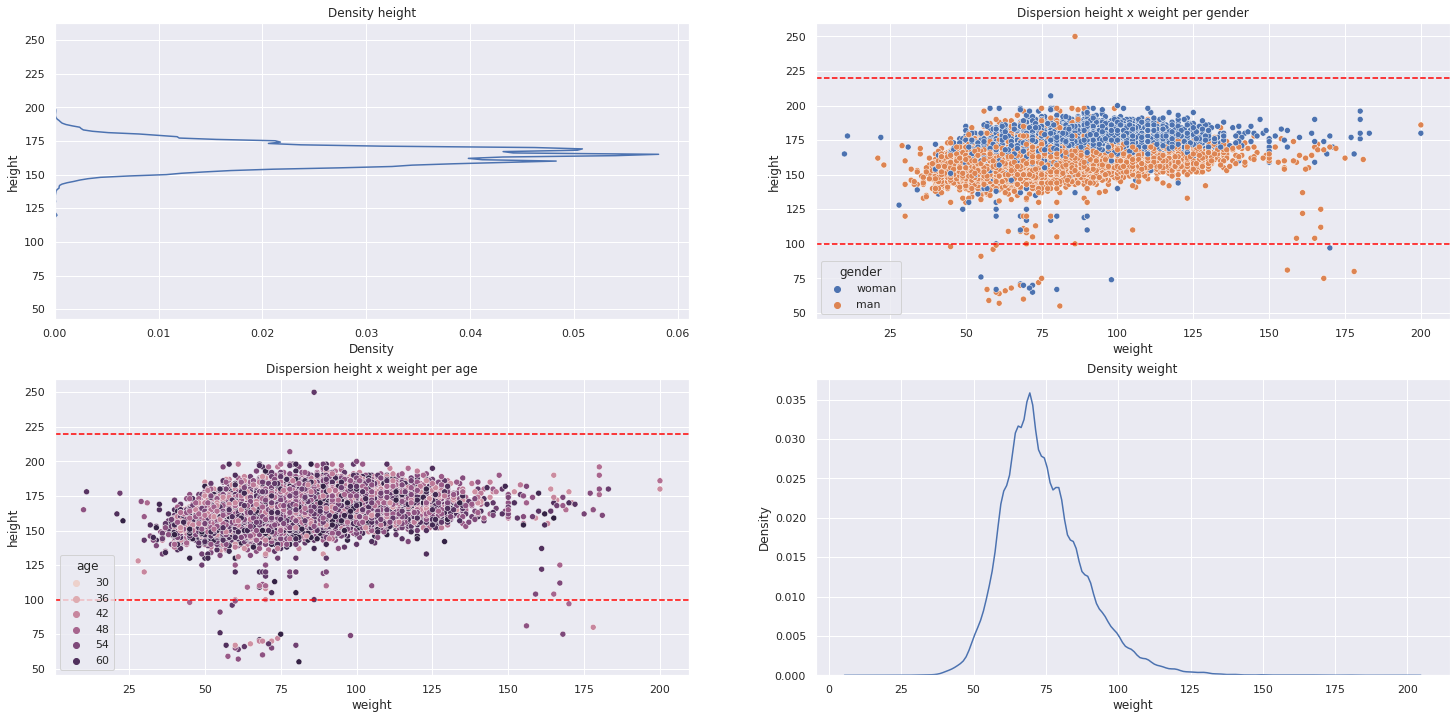

In [21]:
# plot density height
plt.subplot(2, 2, 1)
sns.kdeplot(y='height', data=df4)
plt.title('Density height')

# plot dispersion height x weight x gender
plt.subplot(2, 2, 2)
sns.scatterplot(x='weight', y='height', hue='gender', data=df4)
plt.axhline(y=220, color='red', linestyle='--')
plt.axhline(y=100, color='red', linestyle='--')
plt.title('Dispersion height x weight per gender')

# plot dispersion height x weight x age
plt.subplot(2, 2, 3)
sns.scatterplot(x='weight', y='height', hue='age', data=df4)
plt.axhline(y=220, color='red', linestyle='--')
plt.axhline(y=100, color='red', linestyle='--')
plt.title('Dispersion height x weight per age')

# plot density weight
plt.subplot(2, 2, 4)
sns.kdeplot(x='weight', data=df4)
plt.title('Density weight')

It's possible to identify some **outliers** in the dataset:


<dl>
  <dt>The tallest man in the world measures 2,465 meters.</dt>
  <dd>In the dataset the tallest person is a woman who measures 2.50 meters, clearly a mistake. </dd>
  <dd>For this analysis, only values below 2.10 meters will be considered.</dd>
&nbsp;
  <dt>The dataset has some height values below the average.</dt>
  <dd>The average height in cases of dwarfism is 1.22 meters.</dd>
   <dd>For this analysis, only values greater than 1.10 meters will be considered.</dd>
</dl>

>**height** > 220 -> Exclude

>**height** < 100 -> Exclude

In [22]:
# exclude outliers
df4 = df4[(df4['height'] <= 220) & (df4['height'] >= 100)]

### 4.1.2. BMI

For a more accurate analysis of outliers, the BMI (Body Mass Index) feature was created, represented by the formula:

> **BMI** = Weight(Kg) / [Height(m)]²

Text(0.5, 1.0, 'Dispersion height x bmi per weight')

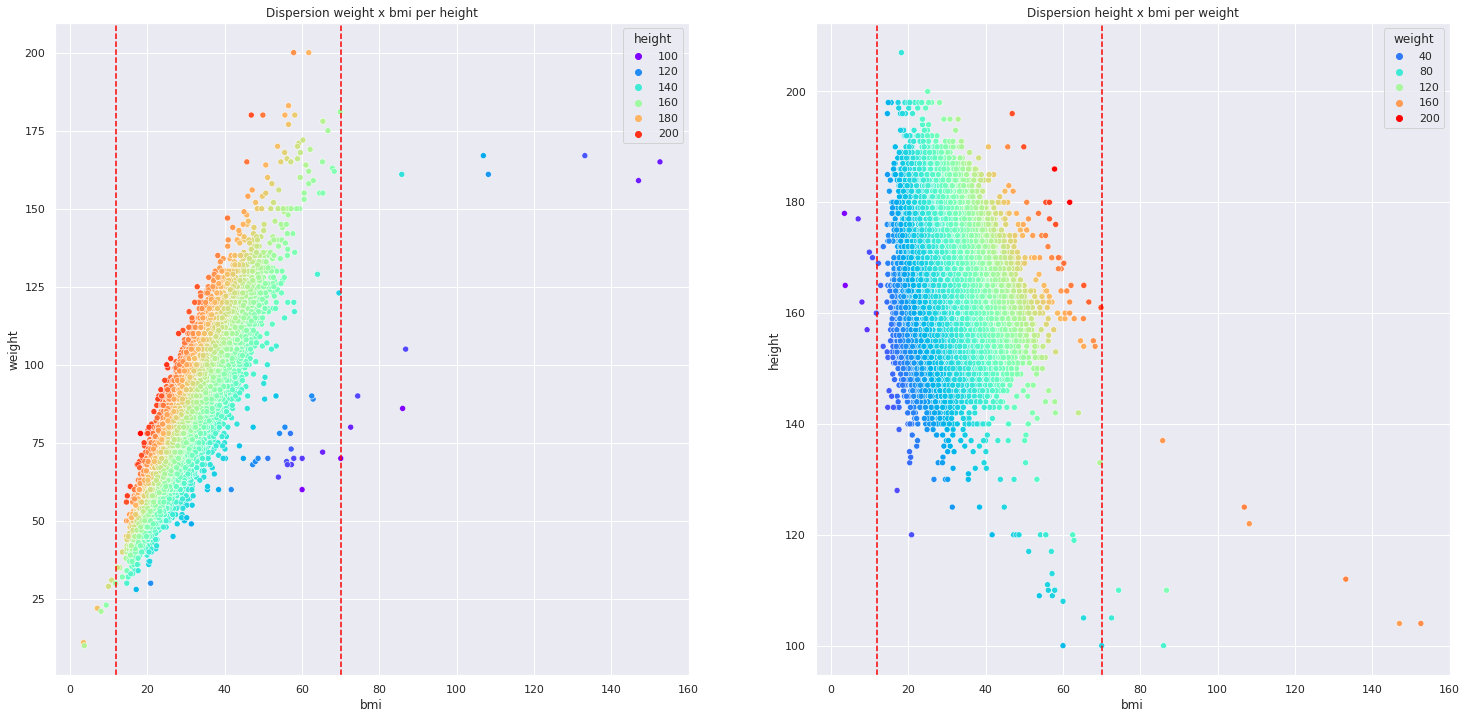

In [23]:
# plot dispersion weight x bmi x height
plt.subplot(1, 2, 1)
sns.scatterplot(x='bmi', y='weight', hue='height', palette='rainbow', data=df4)
plt.axvline(x=12, color='red', linestyle='--')
plt.axvline(x=70, color='red', linestyle='--')
plt.title('Dispersion weight x bmi per height')

# plot dispersion height x bmi x weight
plt.subplot(1, 2, 2)
sns.scatterplot(x='bmi', y='height', hue='weight', palette='rainbow', data=df4)
plt.axvline(x=12, color='red', linestyle='--')
plt.axvline(x=70, color='red', linestyle='--')
plt.title('Dispersion height x bmi per weight')

It's possible to identify some **outliers** in the dataset:


<dl>
  <dt>BMI's higher than 70 and lowest than 12 will be excluded</dt>
</dl>

>**BMI** > 70 --> Exclude

>**BMI** < 12 --> Exclude

In [24]:
# drop outliers
df4 = df4[(df4['bmi'] > 12) & (df4['bmi'] < 70)]

### 4.1.3. p_diastolic x p_systolic

In [25]:
# pre filtering -> filtering values without sense
df4 = df4[(df4['p_systolic'] < 250) & (df4['p_systolic'] > 0)]
df4 = df4[(df4['p_diastolic'] < 150) & (df4['p_diastolic'] > 0)]

Filtering out some values that don't make sense, like negative values and very high outliers, in order to have a better view of the data.

#### 4.1.3.1. p_diastolic > p_systolic

In [26]:
# check values
pressure_input_error = df4.loc[df4['p_diastolic'] > df4['p_systolic'], ['p_systolic', 'p_diastolic']] # some diastolic pressures are bigger than systolic

# drop values than diastolic > systolic
df4 = df4.drop(pressure_input_error.index)

Filtering values where diastolic pressure is higher than systolic pressure.

#### 4.1.3.2. Difference Pressure

Text(0.5, 1.0, 'Boxplot pressure difference')

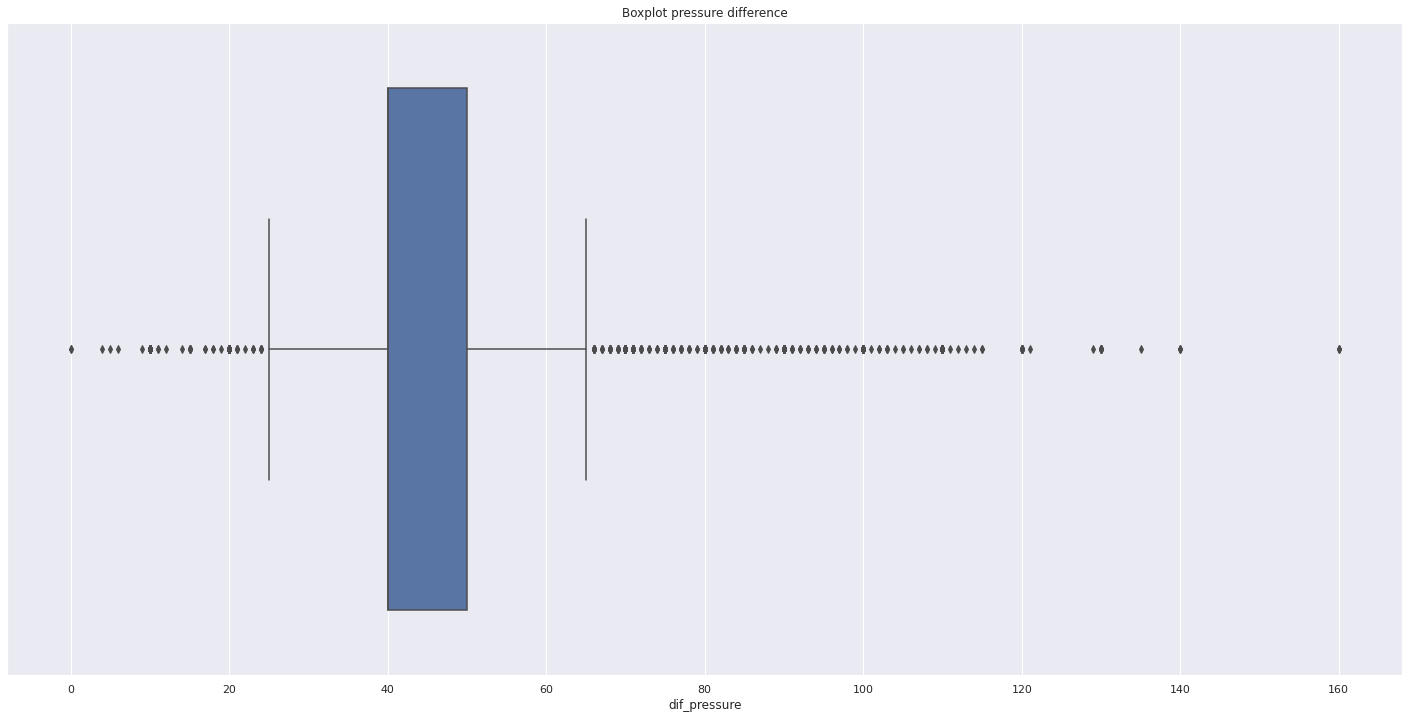

In [27]:
# plot boxplot pressure difference
sns.boxplot(x='dif_pressure', data=df4)
plt.title('Boxplot pressure difference')

To better understand the existing outliers, we will use the outlier detection method using the **IQR** (Inter Quartil Range) formula:

> **IQR** = Q3 - Q1

> **Lower Outlier** = Q1 - (1.5 * IQR)

> **High Outlier** = Q3 + (1.5 * IQR)

In [28]:
# calculating high and low outliers with IQR
high_outlier = df4['dif_pressure'].quantile([0.75]) + (df4['dif_pressure'].quantile([0.75]).values - df4['dif_pressure'].quantile([0.25]).values) * 1.5
low_outlier = df4['dif_pressure'].quantile([0.25]) - (df4['dif_pressure'].quantile([0.75]).values - df4['dif_pressure'].quantile([0.25]).values) * 1.5

# printing high and low outliers
print('High Outlier: {}'.format(high_outlier.values[0]))
print('Low Outlier: {}'.format(low_outlier.values[0]))

High Outlier: 65.0
Low Outlier: 25.0


Larger differences are still possible, but smaller differences(or null) are not possible.

>**Diference** > 100 --> Exclude

>**Diference** < 5 --> Exclude

In [29]:
# drop outliers
df4 = df4[(df4['dif_pressure']<=100) & (df4['dif_pressure']>=10)]

#### 4.1.3.3. High and Low Values

Text(0.5, 1.0, 'Boxplot diastolic pressure')

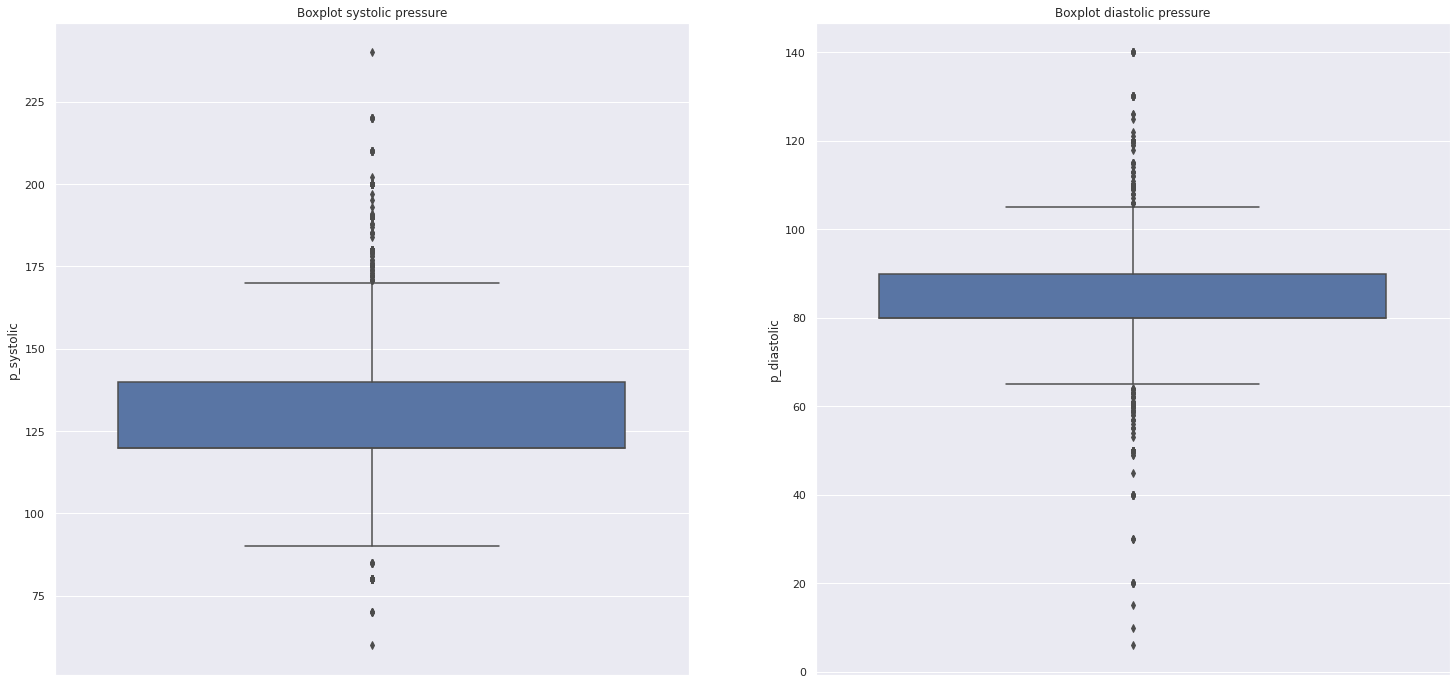

In [30]:
# plot boxplot of systolic pressure
plt.subplot(1, 2, 1)
sns.boxplot(y='p_systolic', data=df4)
plt.title('Boxplot systolic pressure')

# plot boxplot of diastolic pressure
plt.subplot(1, 2, 2)
sns.boxplot(y='p_diastolic', data=df4)
plt.title('Boxplot diastolic pressure')

Text(0.5, 1.0, 'disperion p_systolic x p_diastolic per age')

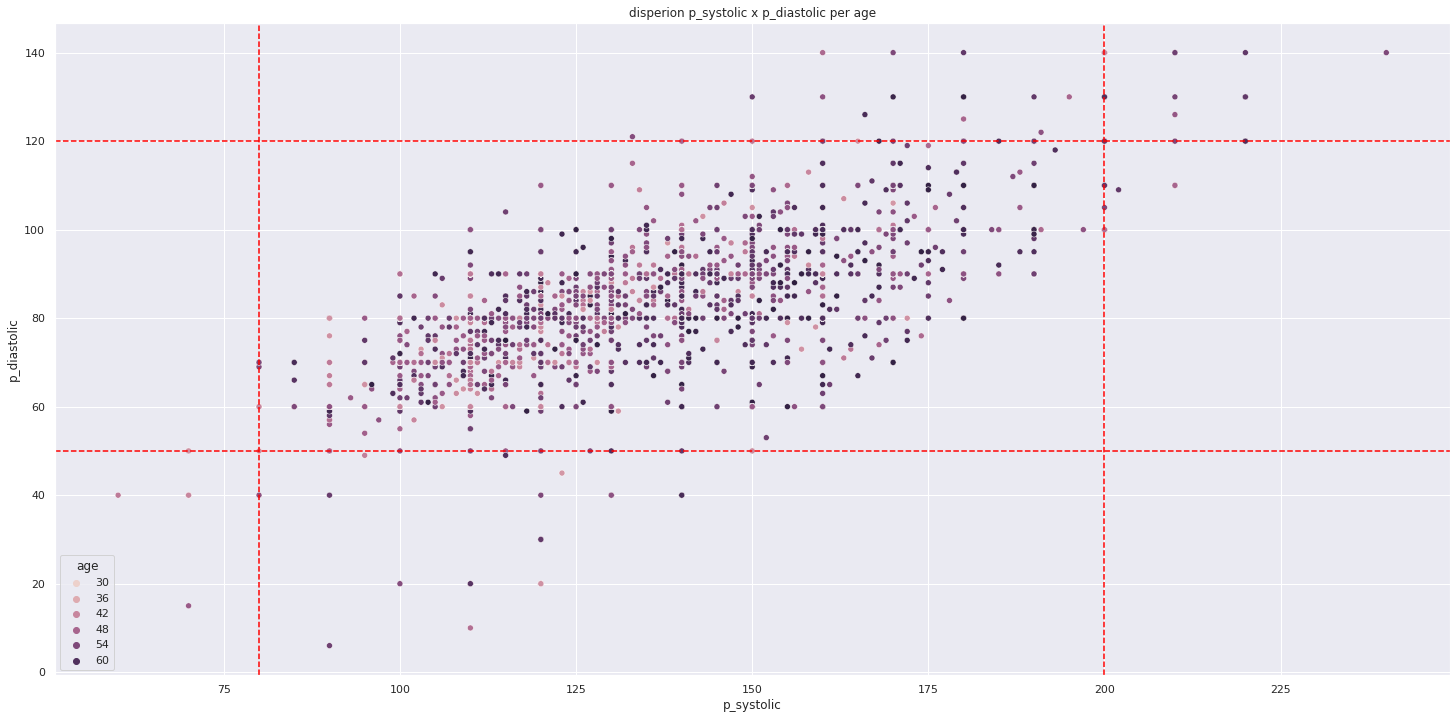

In [31]:
# plot dispersion p_systolic x p_diastolic x age
sns.scatterplot(x='p_systolic', y='p_diastolic', hue='age', data=df4)

# plot cut lines
plt.axvline(x=200, color='red', linestyle='--')
plt.axvline(x=80, color='red', linestyle='--')
plt.axhline(y=120, color='red', linestyle='--')
plt.axhline(y=50, color='red', linestyle='--')

# set title
plt.title('disperion p_systolic x p_diastolic per age')

Using the IQR formula again to identify outliers

In [32]:
# calculating high and low outliers of p_systolic with IQR
high_outlier_hi = df4['p_systolic'].quantile([0.75]) + (df4['p_systolic'].quantile([0.75]).values - df4['p_systolic'].quantile([0.25]).values) * 1.5
low_outlier_hi = df4['p_systolic'].quantile([0.25]) - (df4['p_systolic'].quantile([0.75]).values - df4['p_systolic'].quantile([0.25]).values) * 1.5

# calculating high and low outliers of p_diastolic with IQR
high_outlier_lo = df4['p_diastolic'].quantile([0.75]) + (df4['p_diastolic'].quantile([0.75]).values - df4['p_diastolic'].quantile([0.25]).values) * 1.5
low_outlier_lo = df4['p_diastolic'].quantile([0.25]) - (df4['p_diastolic'].quantile([0.75]).values - df4['p_diastolic'].quantile([0.25]).values) * 1.5

# print high and low outliers of p_diastolic
print('High Outlier from systolic: {}'.format(high_outlier_hi.values[0]))
print('Low Outlier from systolic: {}'.format(low_outlier_hi.values[0]))

print()

# print high and low outliers of p_systolic
print('High Outlier from diastolic: {}'.format(high_outlier_lo.values[0]))
print('Low Outlier from diastolic: {}'.format(low_outlier_lo.values[0]))

High Outlier from systolic: 170.0
Low Outlier from systolic: 90.0

High Outlier from diastolic: 105.0
Low Outlier from diastolic: 65.0


It's possible to identify some **outliers** in the dataset:

<dl>
  <dt>p_systolic higher than 200 and lowest than 80 will be excluded</dt>
  <dt>p_diastolic higher than 120 and lowest than 50 will be excluded</dt>
</dl>

> 80 >= **p_systolic** >= 200 --> Exclude

> 50 >= **p_diastolic** >= 120 --> Exclude

In [33]:
# drop outliers
df4 = df4[(df4['p_systolic'] <= 200) & (df4['p_systolic'] >= 80) & (df4['p_diastolic'] <= 120) & (df4['p_diastolic'] >= 50)]

### 4.1.4 Age

In [34]:
aux1 = df4[df4['age'] < 40]

Text(0.5, 1.0, 'Boxplot Age')

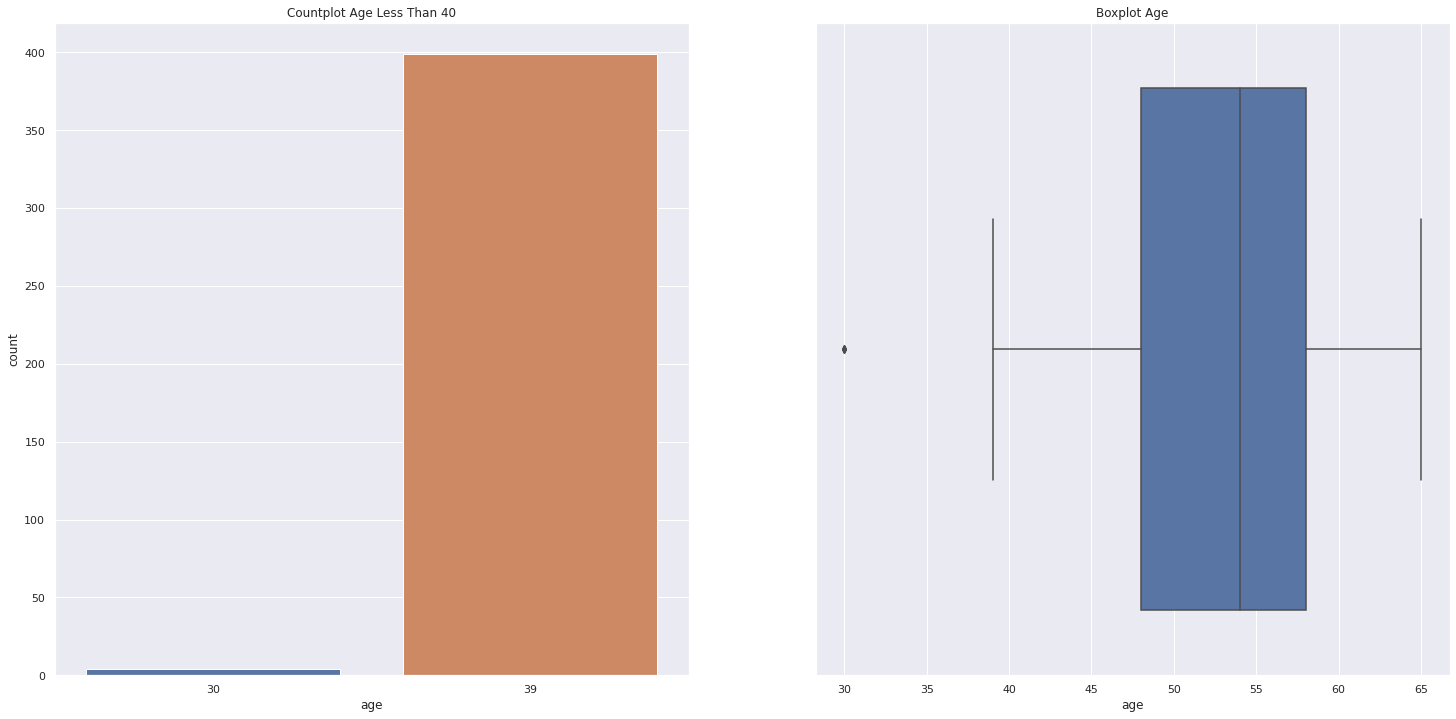

In [35]:
# plot countplot age < 40
plt.subplot(1, 2, 1)
sns.countplot(x = aux1['age'])
plt.title('Countplot Age Less Than 40')

# plot boxplot age
plt.subplot(1, 2, 2)
sns.boxplot(x = df4['age'])
plt.title('Boxplot Age')

In the Dataset there are entries with age 30, which is not necessarily an error, but in the future it may impair the training of the model. In addition, there are only 4 entries, there is no risk of biasing the data.

>**age** = 30 -> drop

In [36]:
df4 = df4[df4['age'] != 30]

## 4.2. Filtering Columns

In [37]:
df4 = df4.drop(['is_o', 'is_d', 'high_c'], axis=1)

## 4.3. Statistical Description - Without Outliers

In [38]:
# DataFrame of num_attributes
num_attributes = df4[['age', 'height', 'weight', 'p_systolic', 'p_diastolic', 'bmi', 'dif_pressure']]

# DataFrame of cat_attributes
cat_attributes = df4[['gender', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cat_bmi',
                      'high_pressure', 'cat_age']]

In [39]:
# calculating percentage of dataset droped
percentage = ((70000 - df4.shape[0]) / 70000) * 100

# print percentage
print('Data Percentage Drop: {:.2f}%'.format(percentage))

Data Percentage Drop: 2.20%


In [40]:
# describe num_attributes
stats_num_describe(num_attributes)

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
age,68462.0,53.325787,6.766186,39.000000,48.000000,54.000000,58.000000,65.000000,26.000000,-0.303271,-0.829099
height,68462.0,164.402632,7.945817,100.000000,159.000000,165.000000,170.000000,207.000000,107.000000,-0.034929,0.988493
weight,68462.0,74.096179,14.263387,28.000000,65.000000,72.000000,82.000000,200.000000,172.000000,0.983918,2.371216
p_systolic,68462.0,126.538824,16.371626,80.000000,120.000000,120.000000,140.000000,200.000000,120.000000,0.819661,1.203583
p_diastolic,68462.0,81.273436,9.278704,50.000000,80.000000,80.000000,90.000000,120.000000,70.000000,0.236925,1.026531
bmi,68462.0,27.455610,5.245037,12.254473,23.875115,26.346494,30.116213,69.534739,57.280266,1.265624,3.007691
dif_pressure,68462.0,45.265388,11.379258,10.000000,40.000000,40.000000,50.000000,100.000000,90.000000,1.148543,2.450749


In [41]:
# describe cat_attributes
cat_attributes.describe()

,smoke,alcohol,active,high_pressure
count,68462.000000,68462.000000,68462.000000,68462.000000
mean,0.087888,0.053285,0.803336,0.341562
std,0.283134,0.224603,0.397479,0.474237
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [42]:
df4.head(10)

,age,gender,height,weight,p_systolic,p_diastolic,cholesterol,glucose,smoke,alcohol,active,cardio,bmi,cat_bmi,high_pressure,count_chronic_diseases,dif_pressure,cat_age
0,50,woman,168,62.0,110,80,normal,normal,0,0,1,0,21.967120,normal,0,0,30,50 - 59
1,55,man,156,85.0,140,90,well_above_normal,normal,0,0,1,1,34.927679,obese,1,3,50,50 - 59
2,52,man,165,64.0,130,70,well_above_normal,normal,0,0,0,1,23.507805,normal,0,1,60,50 - 59
3,48,woman,169,82.0,150,100,normal,normal,0,0,1,1,28.710479,overwight,1,1,50,39 - 49
4,48,man,156,56.0,100,60,normal,normal,0,0,0,0,23.011177,normal,0,0,40,39 - 49
5,60,man,151,67.0,120,80,above_normal,above_normal,0,0,0,0,29.384676,overwight,0,2,40,60 - 65
6,61,man,157,93.0,130,80,well_above_normal,normal,0,0,1,0,37.729725,extremely obese,0,2,50,60 - 65
7,62,woman,178,95.0,130,90,well_above_normal,well_above_normal,0,0,1,1,29.983588,overwight,1,3,40,60 - 65
8,48,man,158,71.0,110,70,normal,normal,0,0,1,0,28.440955,overwight,0,0,40,39 - 49
9,54,man,164,68.0,110,60,normal,normal,0,0,0,0,25.282570,overwight,0,0,50,50 - 59


# 5.0. EXPLORATORY DATA ANALYSIS

In [43]:
# only to EDA
df5 = df4.copy()

# active
df5['active'] = df5['active'].map({0: 'no', 1: 'yes'})

# smoke
df5['smoke'] = df5['smoke'].map({0: 'no', 1: 'yes'})

# alcohol
df5['alcohol'] = df5['alcohol'].map({0: 'no', 1: 'yes'})

# high_pressure
df5['high_pressure'] = df5['high_pressure'].map({0: 'no', 1: 'yes'})

## 5.1. Univariate Analysis

### 5.1.2. Response Variable

<AxesSubplot:xlabel='cardio', ylabel='count'>

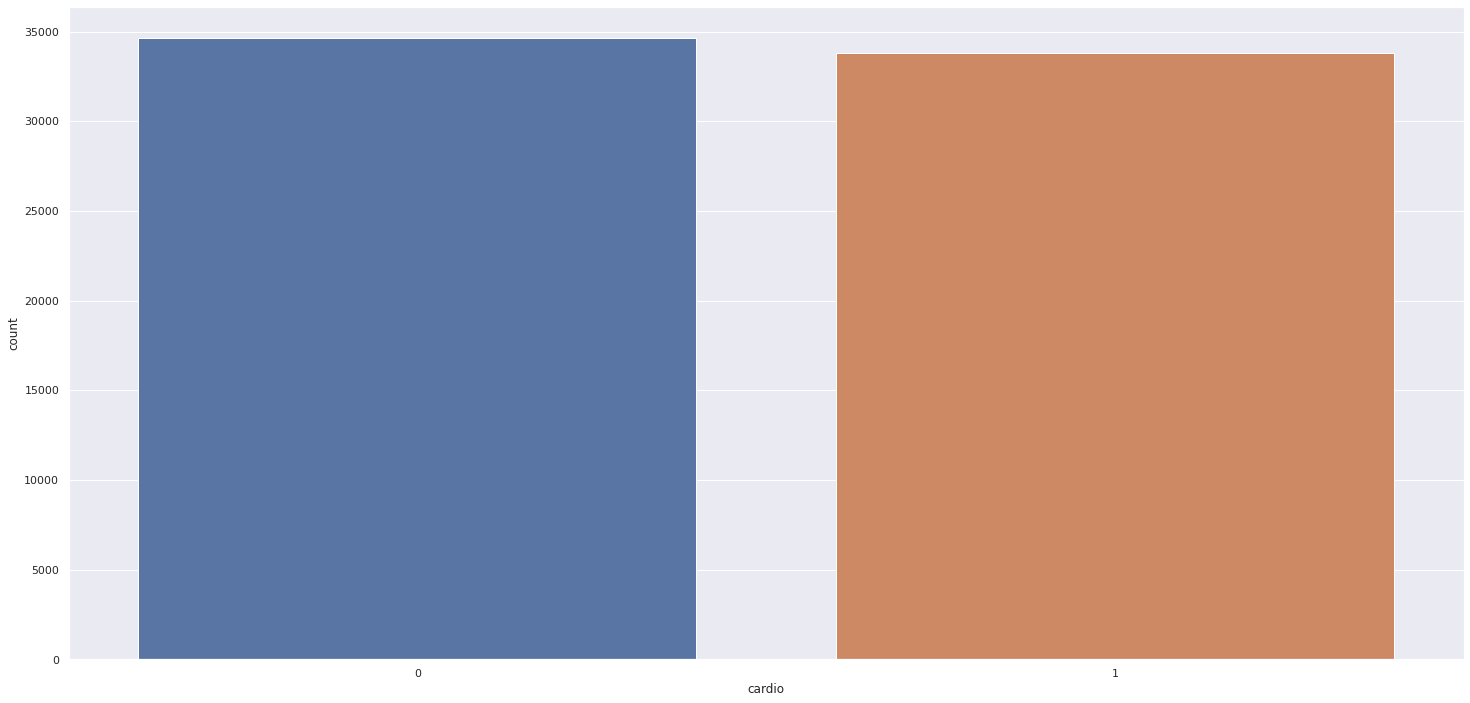

In [44]:
# plot countplot of variable response
sns.countplot(x='cardio', data=df5)

### 5.1.2. Numerical Variables

In [45]:
# set numerical attributes list
num_attributes = df5[['age', 'height', 'weight', 'p_systolic', 'p_diastolic', 'bmi', 'dif_pressure', 'count_chronic_diseases']]

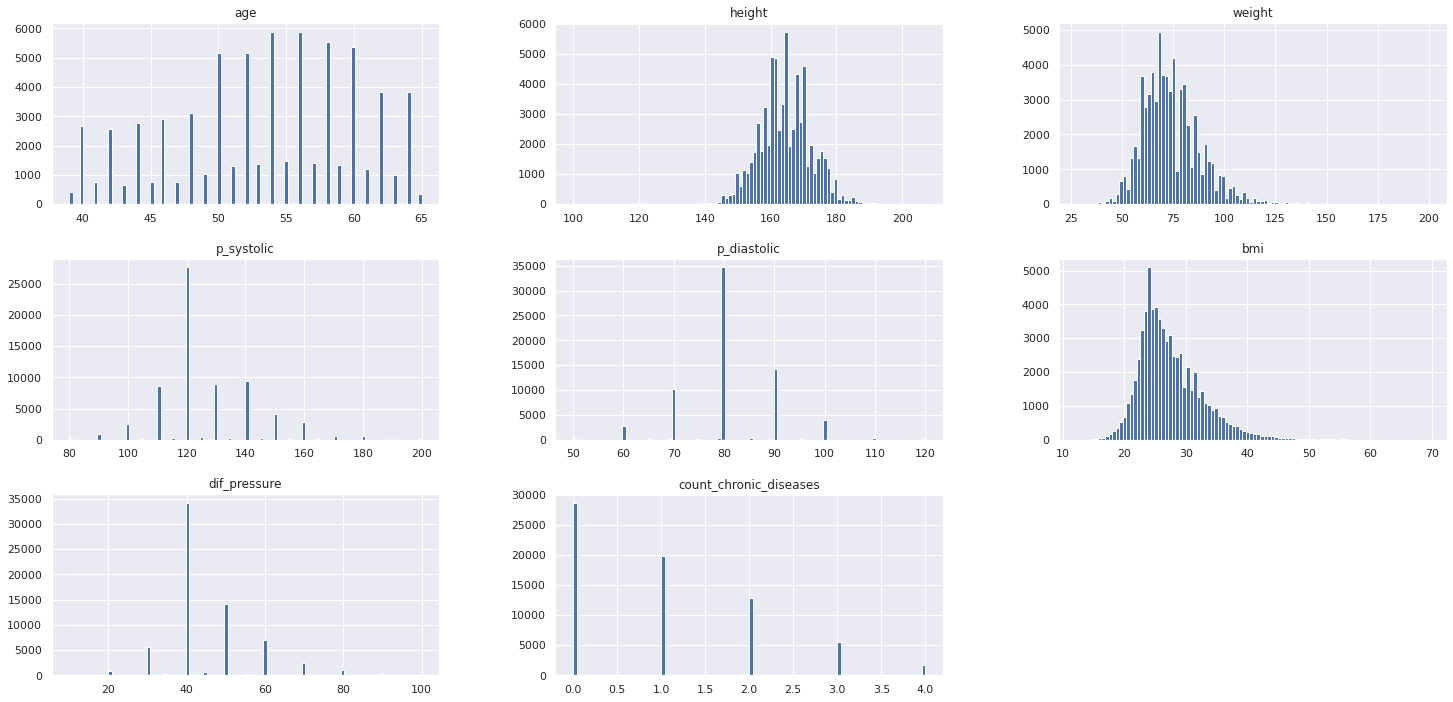

In [46]:
# plot numerical variables
num_attributes.hist( bins=100 );

### 5.1.3. Categorical Variables

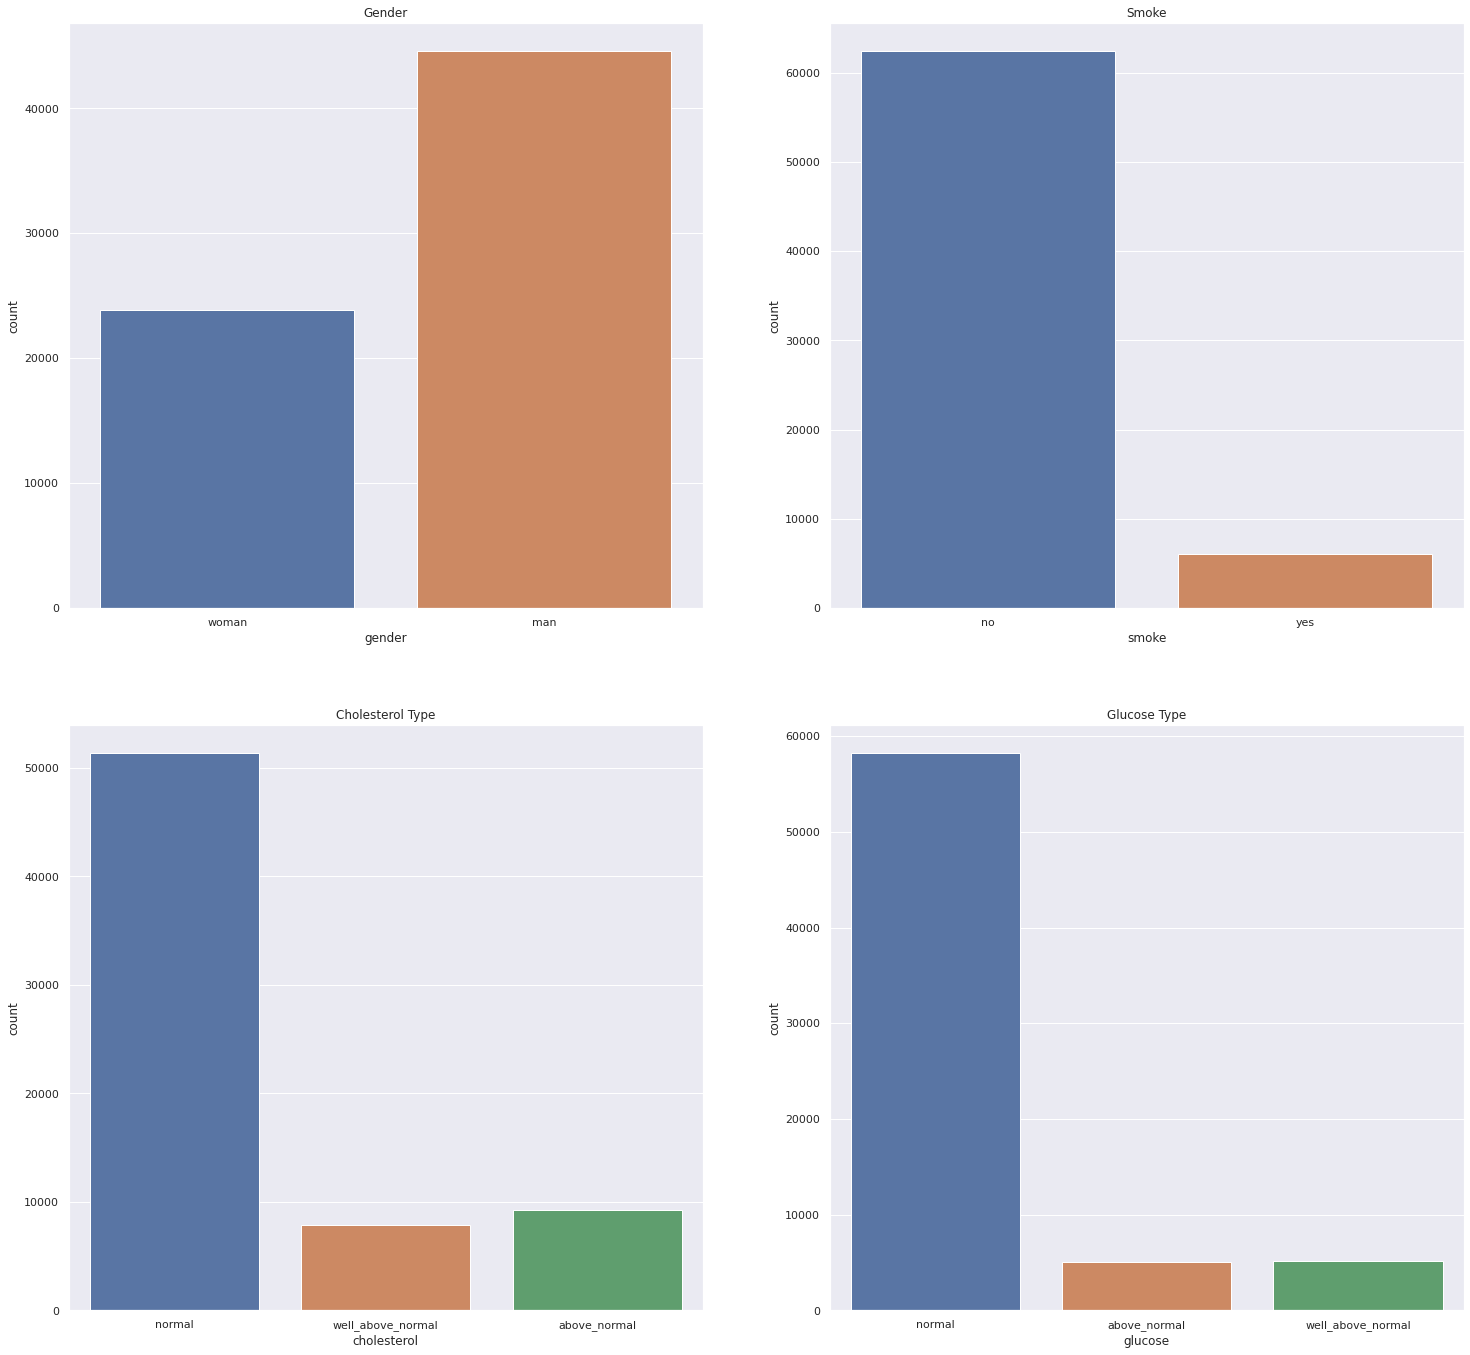

In [47]:
grid = plt.GridSpec(2, 2)

# plot gender
plt.subplot(grid[0, 0])
sns.countplot(x='gender', data=df5)
plt.title('Gender')

# plot smoke
plt.subplot(grid[0, 1])
sns.countplot(x='smoke', data=df5)
plt.title('Smoke')

# plot cholesterol
plt.subplot(grid[1, 0])
sns.countplot(x='cholesterol', data=df5)
plt.title('Cholesterol Type')

# plot glucose
plt.subplot(grid[1, 1])
sns.countplot(x='glucose', data=df5)
plt.title('Glucose Type')

# plot adjusts
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.2, 
                    hspace=0.20)

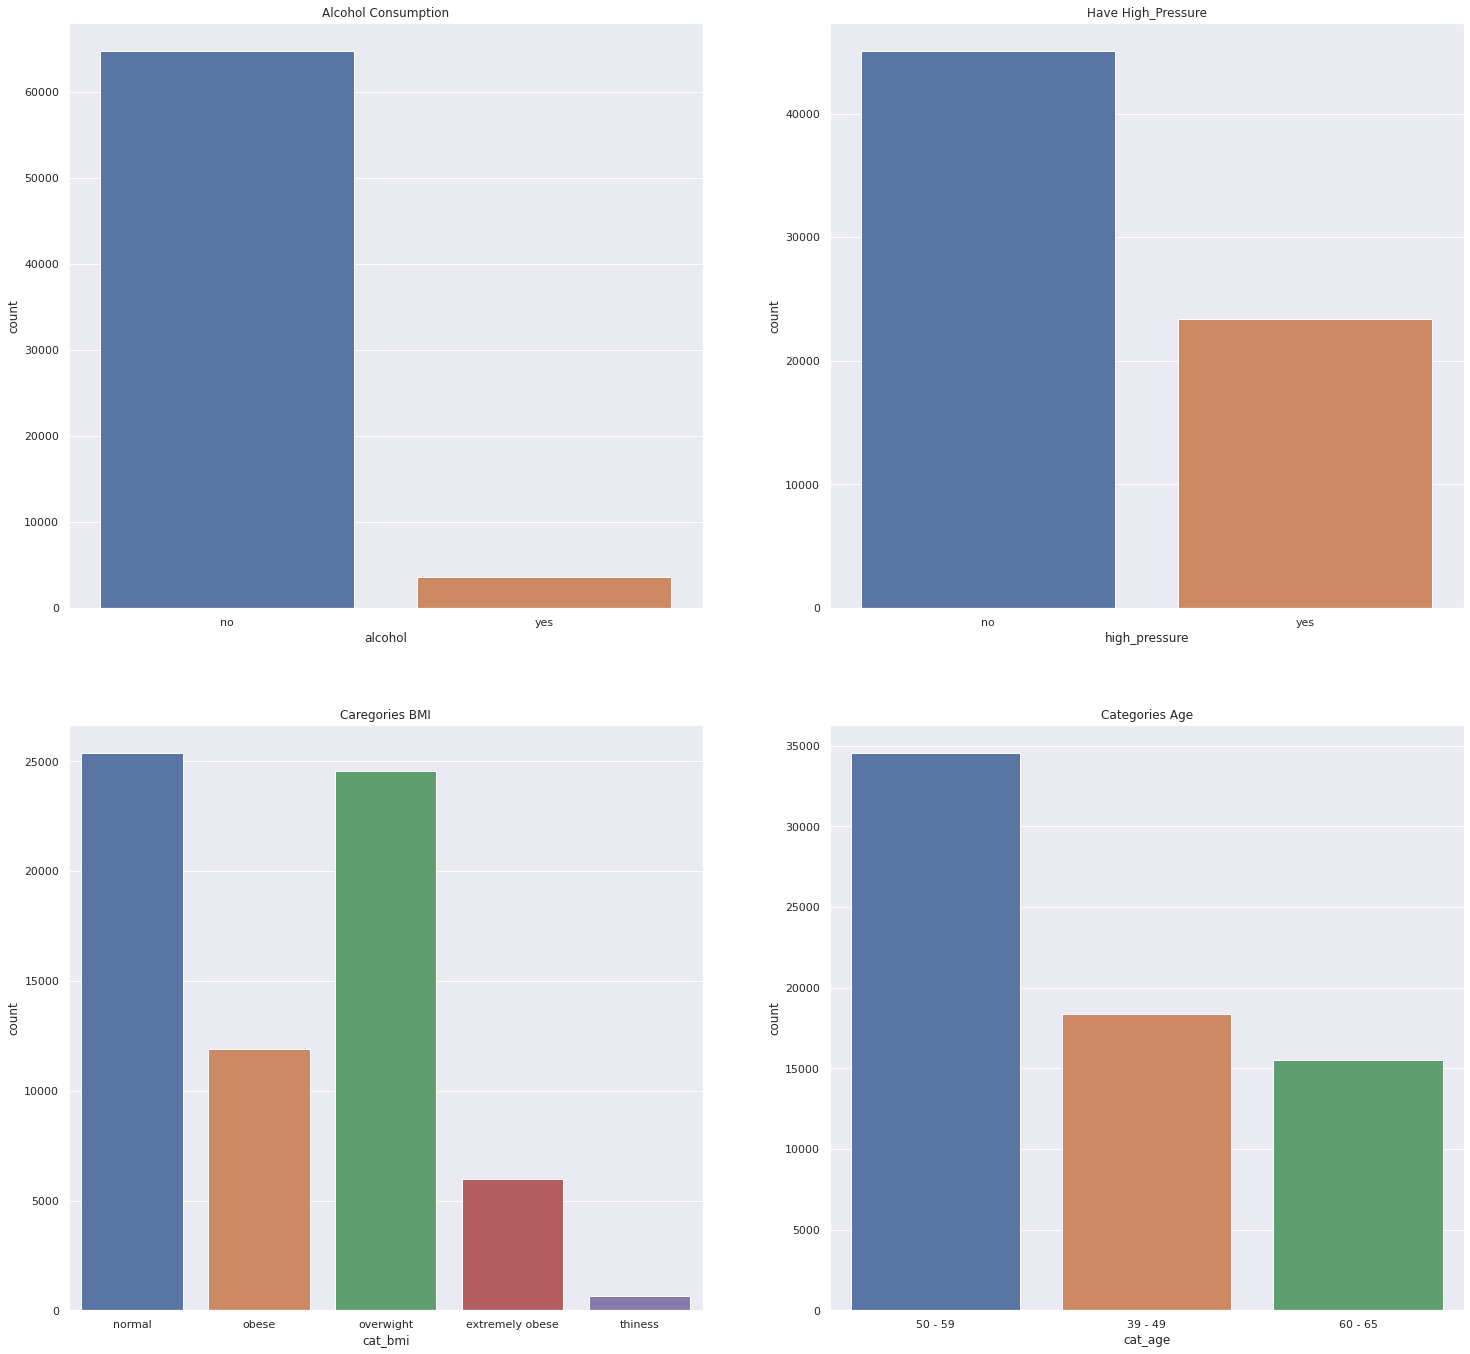

In [48]:
grid = plt.GridSpec(2, 2)

# plot alcohol
plt.subplot(grid[0, 0])
sns.countplot(x='alcohol', data=df5)
plt.title('Alcohol Consumption')

# plot high_pressure
plt.subplot(grid[0, 1])
sns.countplot(x='high_pressure', data=df5)
plt.title('Have High_Pressure')

# plot cat_bmi
plt.subplot(grid[1, 0])
sns.countplot(x='cat_bmi', data=df5)
plt.title('Caregories BMI')

# plot cat_age
plt.subplot(grid[1, 1])
sns.countplot(x='cat_age', data=df5)
plt.title('Categories Age')

# plot adjusts
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.2, 
                    hspace=0.20)

## 5.2. Bivariate Analysis

### H1. People with high BMI are more likely to have cardiovascular diseases - TRUE

In [49]:
# auxiliar DF 1 - groupby bmi and cardio - mean
aux1 = df5[['bmi', 'cardio']].groupby('cardio').mean().reset_index()

Text(0.5, 1.0, 'Count Each Categoric BMI Cardio Case')

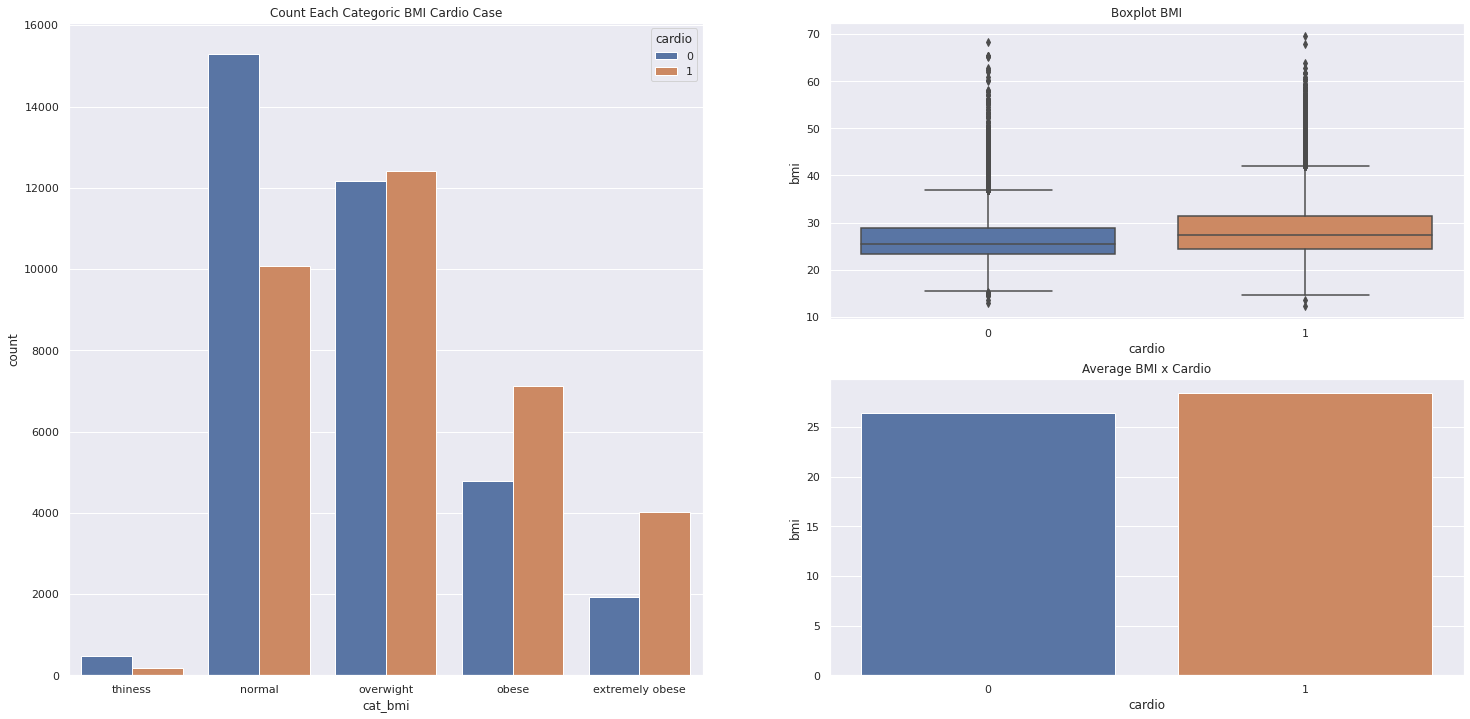

In [50]:
grid = plt.GridSpec(2, 2)

# plot botplox cardio x bmi
plt.subplot(grid[0, 1])
sns.boxplot(x='cardio', y='bmi', data=df5)
plt.title('Boxplot BMI')

# plot barplot average bmi x cardio
plt.subplot(grid[1, 1])
sns.barplot(y='bmi', x='cardio', data=aux1)
plt.title('Average BMI x Cardio')

# plot countplot cat_bmi with hue cardio
plt.subplot(grid[:, 0])
sns.countplot(x='cat_bmi', hue='cardio', order=['thiness', 'normal', 'overwight', 'obese', 'extremely obese'], data=df5)
plt.title('Count Each Categoric BMI Cardio Case')

> The hypothesis is **True**

### H2. Older people are more likely to have cardiovascular diseases- TRUE

In [51]:
# auxiliar DF 1 - groupby age and cardio - mean
aux1 = df5[['age', 'cardio']].groupby('cardio').mean().reset_index()

Text(0.5, 1.0, 'Average Age x Cardio')

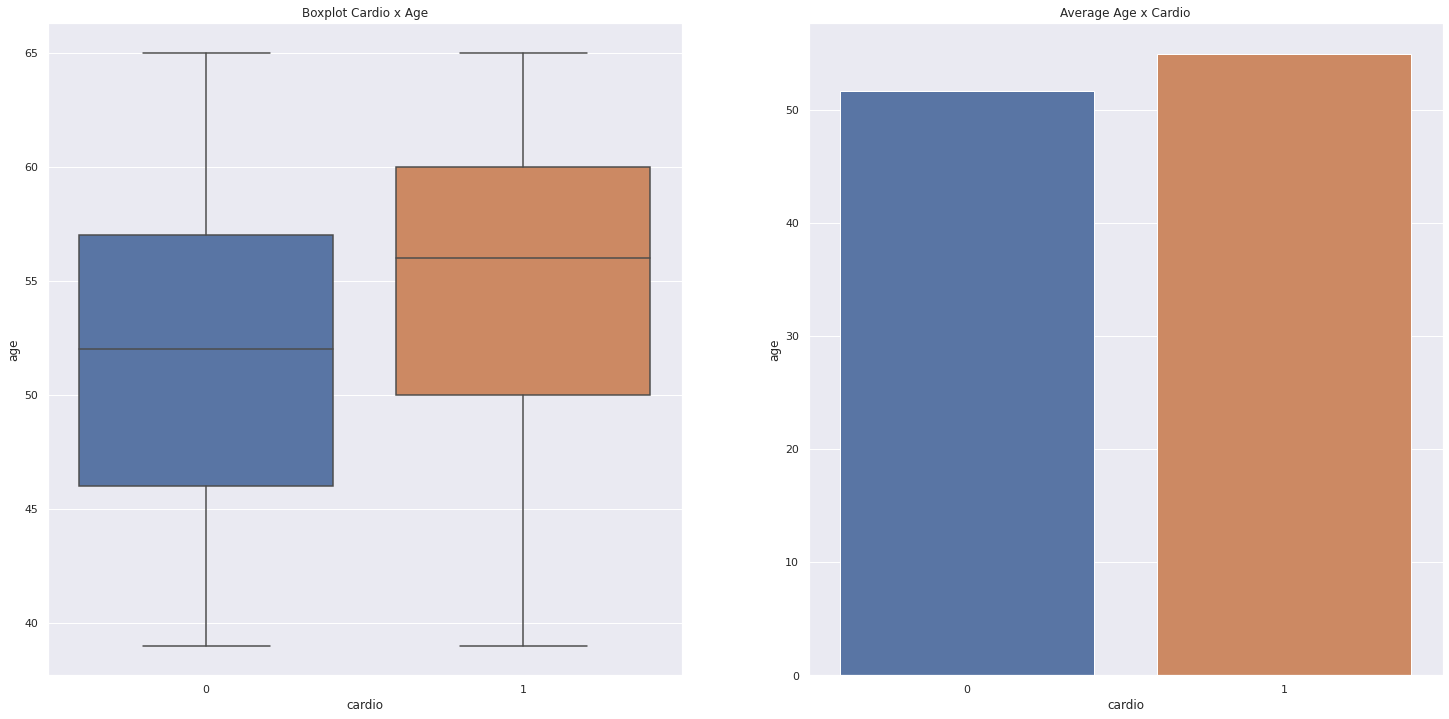

In [52]:
# plot Boxplot cardio x age
plt.subplot(1, 2, 1)
sns.boxplot(y='age', x='cardio', data=df5)
plt.title('Boxplot Cardio x Age')

# plot barplot of average age x cardio
plt.subplot(1, 2, 2)
sns.barplot(y='age', x='cardio', data=aux1)
plt.title('Average Age x Cardio')

> The hypothesis is **True**

### H3. Gender does not influence people's chances of having cardiovascular diseases - TRUE

Text(0.5, 1.0, 'Boxplot Gender x Cardio')

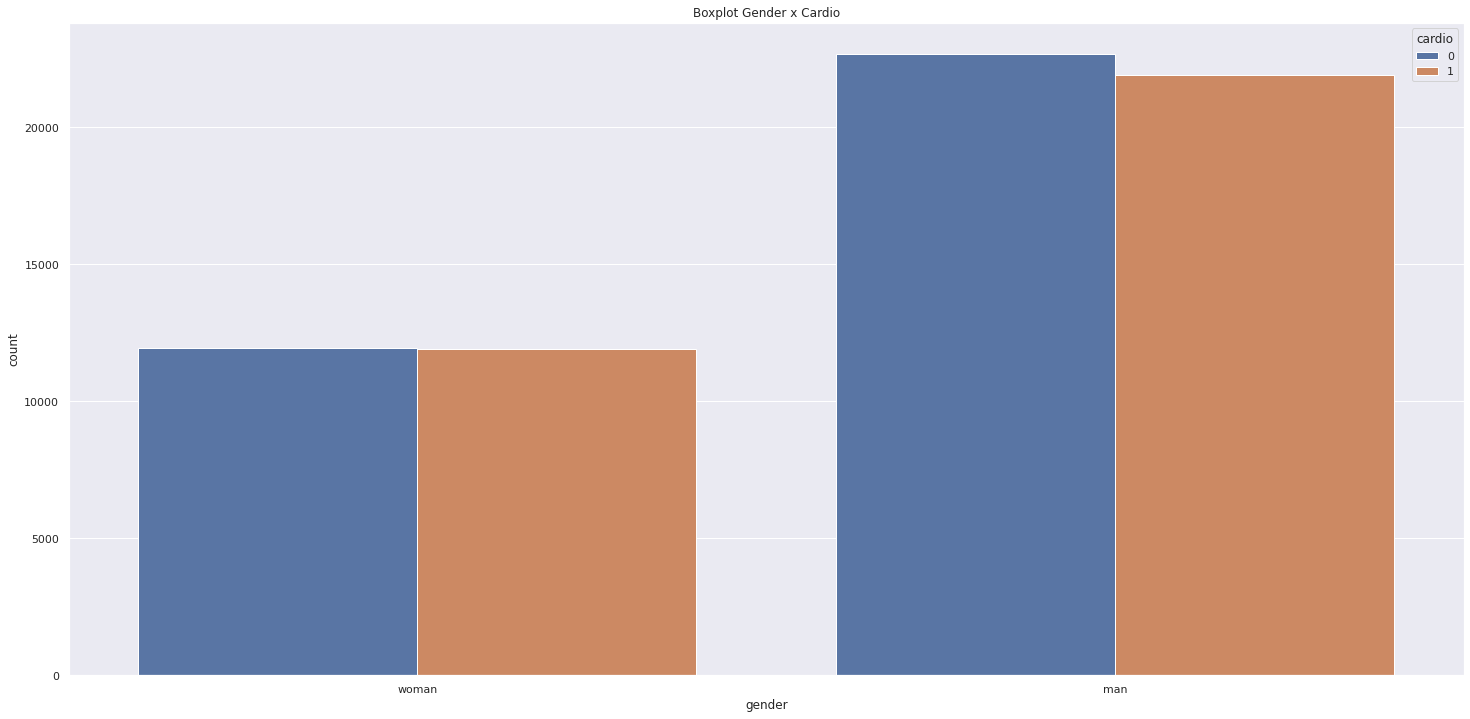

In [53]:
# plot countplor gender x cardio
plt.subplot(1, 1, 1)
sns.countplot(x='gender', hue='cardio', data=df5)
plt.title('Boxplot Gender x Cardio')

In [54]:
# calculating the correlation of gender and cardio
corr = cramer_v(df5['gender'], df5['cardio'])

In [55]:
# print the correlation
print('The correlation between the variables is: {:.3f}'.format(corr))

The correlation between the variables is: 0.007


> The hypothesis is **True**

### H4. Older people are more likely to have more cardiovascular diseases than young people with obesity - TRUE

In [56]:
# create aux3 - percentage of overwight, obese and extremely obese per age
# create aux1 and aux2 - count and sum
aux1 = df5[['cat_age', 'cat_bmi', 'cardio']].groupby(['cat_bmi', 'cat_age']).sum().reset_index()
aux2 = df5[['cat_age', 'cat_bmi', 'cardio']].groupby(['cat_bmi', 'cat_age']).count().reset_index()

# create aux3 - merge
aux3 = pd.merge(left=aux1, right=aux2, on=['cat_bmi', 'cat_age'])

# selecting only categories of interest
aux3 = aux3[(aux3['cat_bmi'] == 'extremely obese') | (aux3['cat_bmi'] == 'obese') | (aux3['cat_bmi'] == 'overwight')].groupby('cat_age').sum().reset_index()

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# aux3 final
aux3 = aux3[['cat_age', 'percentage']]

# create aux4 to plot heatmap and regplot
aux4 = aux3
aux4['age'] = [40, 50, 60]
aux4 = aux4[['age', 'percentage']]

Text(0.5, 1.0, 'Percentage x Age')

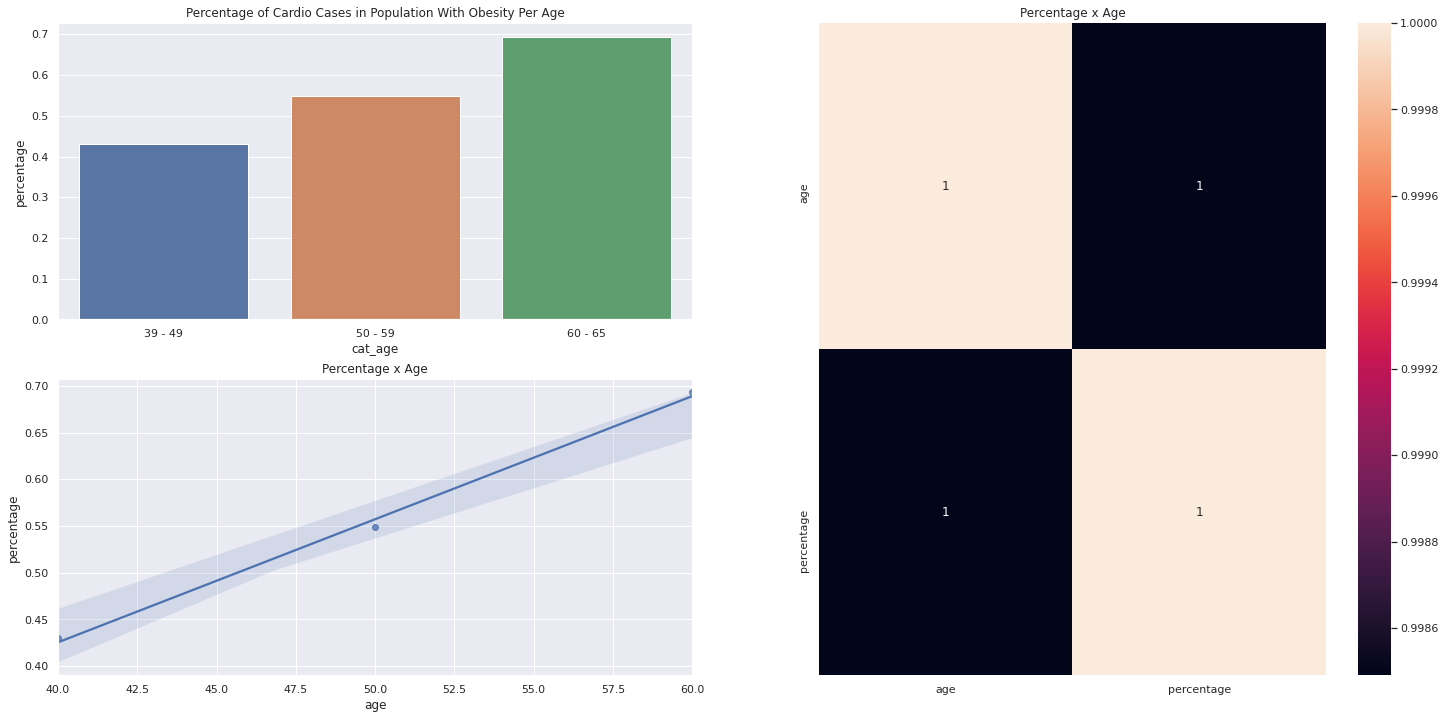

In [57]:
grid = plt.GridSpec(2, 2)

# plot barplot percentage x cat_age
plt.subplot(grid[0, 0])
sns.barplot(y='percentage', x='cat_age', data=aux3)
plt.title('Percentage of Cardio Cases in Population With Obesity Per Age')

# plot regplot age x percentage
plt.subplot(grid[1, 0])
sns.regplot(x='age', y='percentage', data=aux4)
plt.title('Percentage x Age')

# plot heatmap - correlation
plt.subplot(grid[:, 1])
sns.heatmap(aux4.corr(method='pearson'), annot=True)
plt.title('Percentage x Age')

> The hypothesis is **True**

### H5. People with more chronic diseases are more likely to have cardiovascular diseases - TRUE

In [58]:
# create aux3 - percentage of cardio in count_chronic diseases
# create aux1 and aux2 - count and sum
aux1 = df5[['cardio', 'count_chronic_diseases']].groupby('count_chronic_diseases').count()
aux2 = df5[['cardio', 'count_chronic_diseases']].groupby('count_chronic_diseases').sum()

# create aux3 - merge
aux3 = pd.merge(left=aux2, right=aux1, on='count_chronic_diseases').reset_index()

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# final aux3
aux3 = aux3[['count_chronic_diseases', 'percentage']]

Text(0.5, 1.0, 'Percentage x Count of Chronic Diseases')

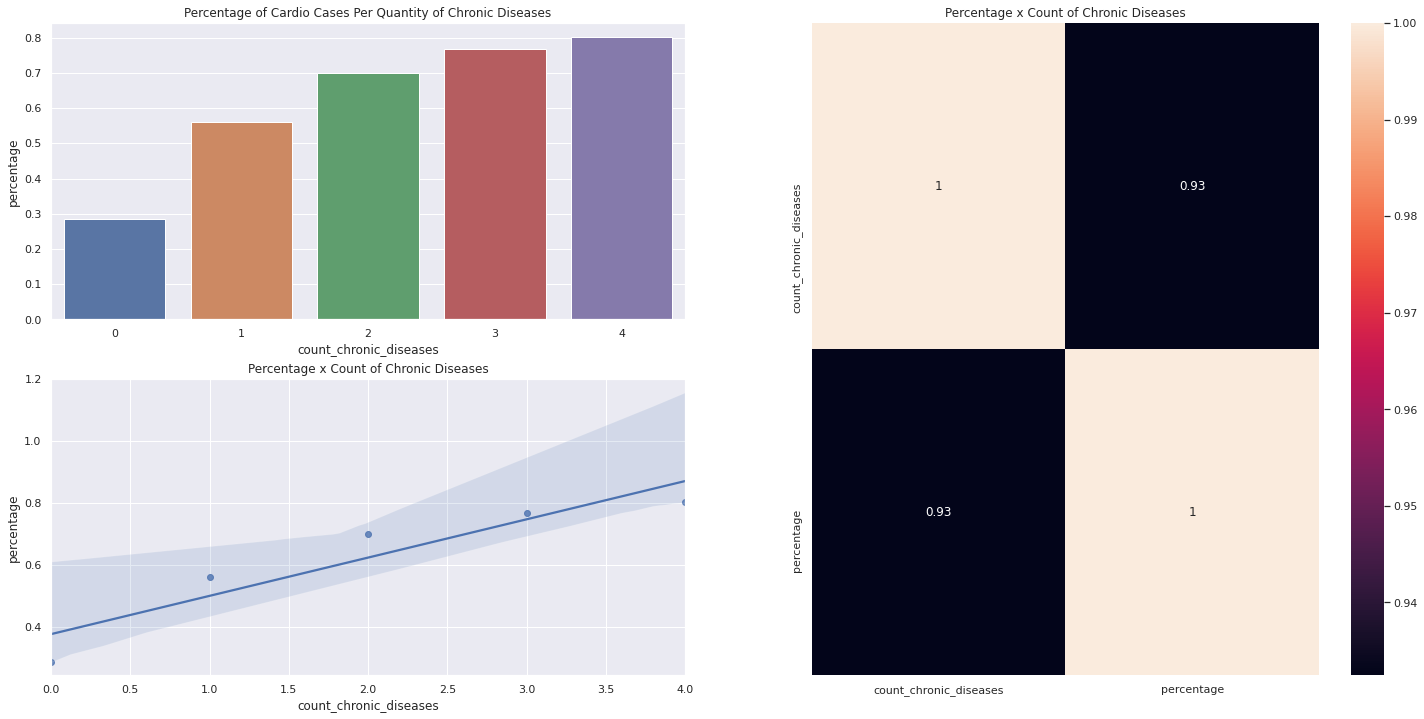

In [59]:
grid = plt.GridSpec(2, 2)

# plot barplot percentage x count_chronic_diseases
plt.subplot(grid[0, 0])
sns.barplot(x='count_chronic_diseases', y='percentage', data=aux3)
plt.title('Percentage of Cardio Cases Per Quantity of Chronic Diseases')

# plot regplot count_chronic_diseases x percentage
plt.subplot(grid[1, 0])
sns.regplot(x='count_chronic_diseases', y='percentage', data=aux3)
plt.title('Percentage x Count of Chronic Diseases')

# plot heatmap count_chronic_diseases x percentage
plt.subplot(grid[:, 1])
sns.heatmap(aux3.corr(method='pearson'), annot=True)
plt.title('Percentage x Count of Chronic Diseases')

> The hypothesis is **True**

### H6. People with high cholesterol are more likely to have cardiovascular diseases - TRUE

In [60]:
# create aux3 - percentage of cardio in cholesterol type
# create aux1 and aux2 - count and sum
aux1 = df5[['cholesterol', 'cardio']].groupby('cholesterol').sum().reset_index()
aux2 = df5[['cholesterol', 'cardio']].groupby('cholesterol').count().reset_index()

# create aux3 - merge
aux3 = pd.merge(left = aux1, right = aux2, on='cholesterol')

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# final aux3
aux3 = aux3[['cholesterol', 'percentage']]

# create aux4 to plot heatmap and regplot
aux4 = aux3.copy()
aux4['cholesterol'] = aux3['cholesterol'].map({'normal': 1, 'above_normal': 2, 'well_above_normal': 3})

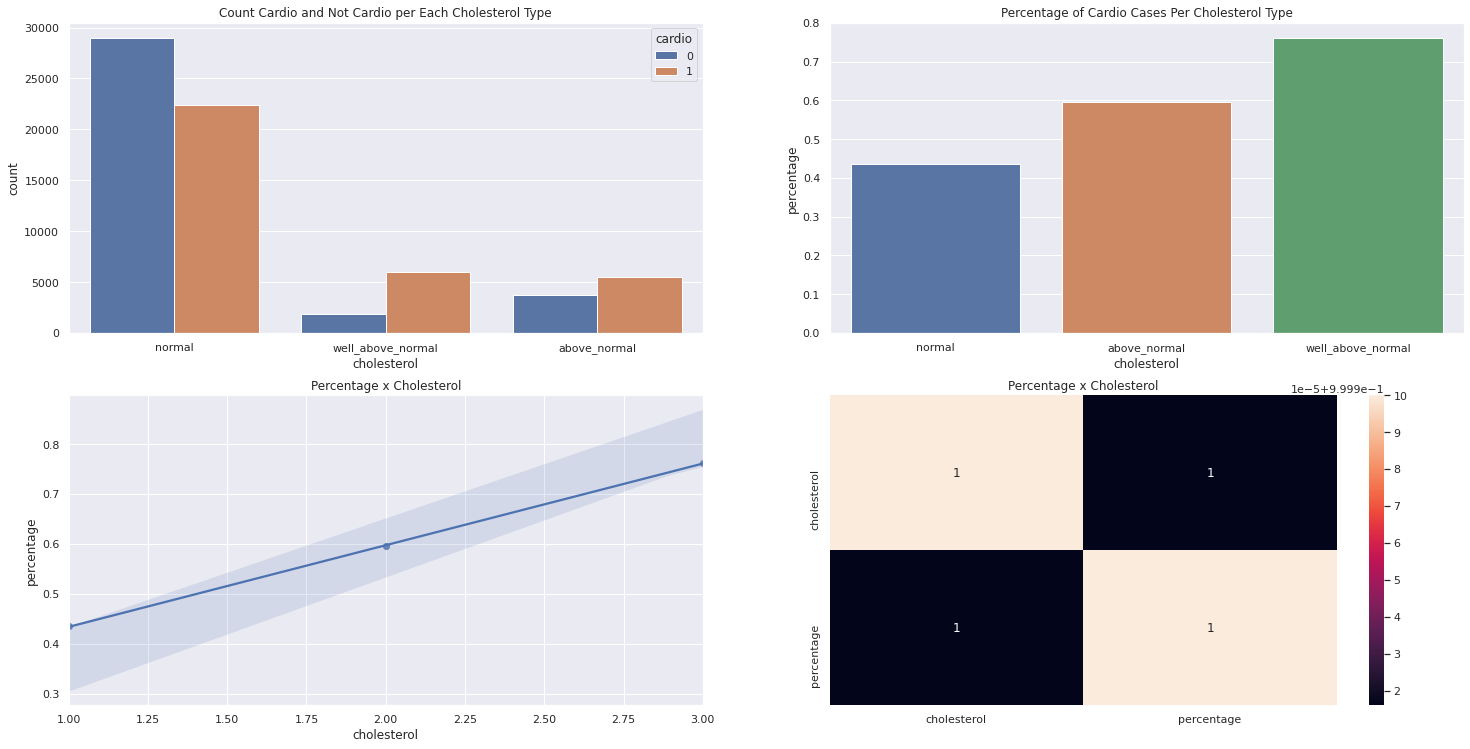

In [61]:
# plot countplot cholesterol x cardio
plt.subplot(2, 2, 1)
sns.countplot(x='cholesterol', hue='cardio', data=df5)
plt.title('Count Cardio and Not Cardio per Each Cholesterol Type')

# plot barplot percentage x cholesterol
plt.subplot(2, 2, 2)
sns.barplot(x='cholesterol', y='percentage', data=aux3, order=['normal', 'above_normal', 'well_above_normal'])
plt.title('Percentage of Cardio Cases Per Cholesterol Type')

# plot regplot cholesterol x percentage
plt.subplot(2, 2, 3)
sns.regplot(x='cholesterol', y='percentage', data=aux4)
plt.title('Percentage x Cholesterol')

# plot heatmap cholesterol x percentage
plt.subplot(2, 2, 4)
sns.heatmap(aux4.corr(method='pearson'), annot=True)
plt.title('Percentage x Cholesterol')

# plot adjusts
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.20)

> The hypothesis is **True**

### H7. People with high glucose are more likely to have cardiovascular diseases - TRUE

In [62]:
# create aux3 - percentage of cardio in glucose
# create aux1 and aux2 - count and sum
aux1 = df5[['glucose', 'cardio']].groupby('glucose').sum().reset_index()
aux2 = df5[['glucose', 'cardio']].groupby('glucose').count().reset_index()

# create aux3 - merge
aux3 = pd.merge(left = aux1, right = aux2, on='glucose')

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# final aux3
aux3 = aux3[['glucose', 'percentage']]

# create aux4 to plot heatmap and regplot
aux4 = aux3.copy()
aux4['glucose'] = aux3['glucose'].map({'normal': 1, 'above_normal': 2, 'well_above_normal': 3})

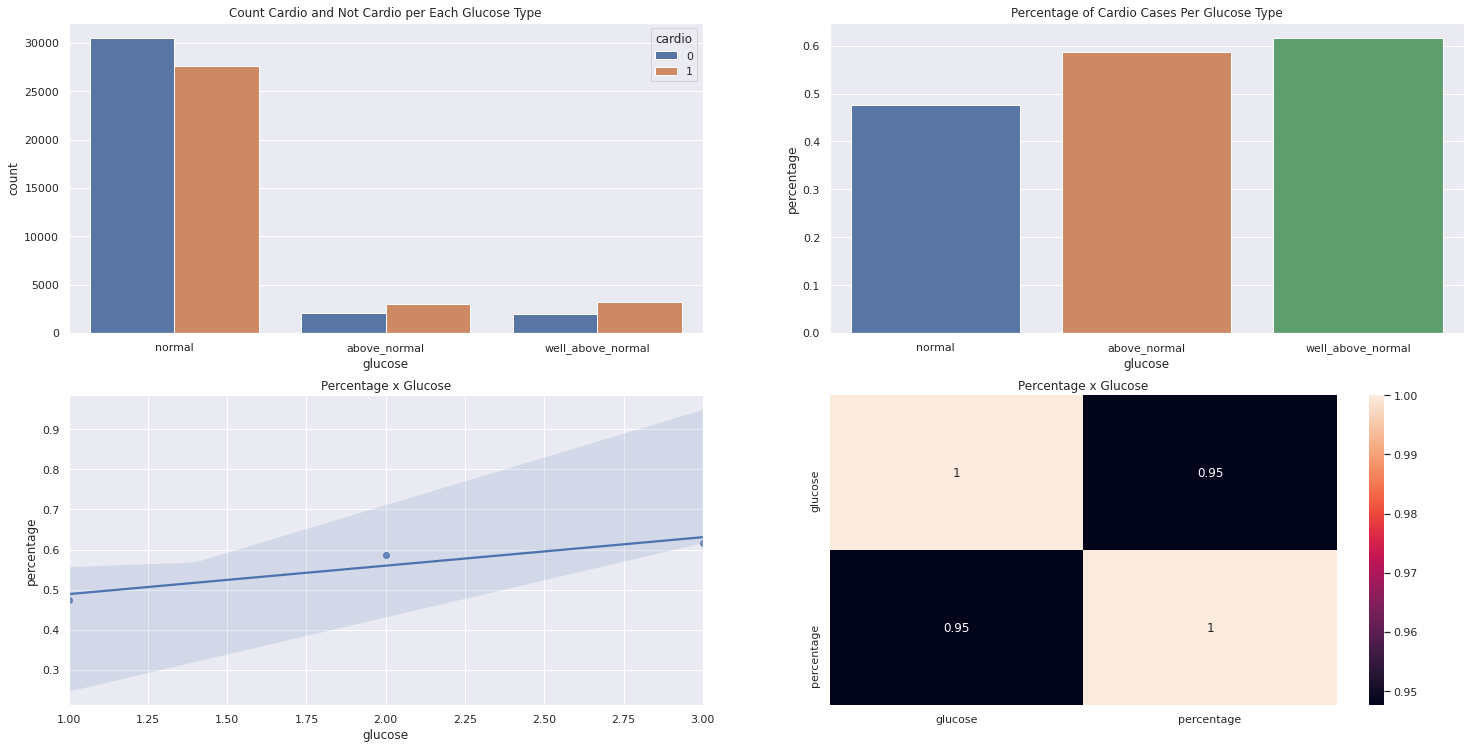

In [63]:
# plot countplot glucose x cardio
plt.subplot(2, 2, 1)
sns.countplot(x='glucose', hue='cardio', data=df5)
plt.title('Count Cardio and Not Cardio per Each Glucose Type')

# plot barplot percentage x glucose
plt.subplot(2, 2, 2)
sns.barplot(x='glucose', y='percentage', data=aux3, order=['normal', 'above_normal', 'well_above_normal'])
plt.title('Percentage of Cardio Cases Per Glucose Type')

# plot regplot glucose x percentage
plt.subplot(2, 2, 3)
sns.regplot(x='glucose', y='percentage', data=aux4)
plt.title('Percentage x Glucose')

# plot heatmap glucose x percentage
plt.subplot(2, 2, 4)
sns.heatmap(aux4.corr(method='pearson'), annot=True)
plt.title('Percentage x Glucose')

# plot adjusts
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.20)

> The hypothesis is **True**

### H8. People who practice physical activities are least likely to have cardiovascular diseases - TRUE

In [64]:
# create aux3 - percentage of cardio in active
# create aux1 and aux2 - count and sum
aux1 = df5[['active', 'cardio']].groupby('active').sum().reset_index()
aux2 = df5[['active', 'cardio']].groupby('active').count().reset_index()

# create aux3 - merge
aux3 = pd.merge(left=aux1, right=aux2, on='active')

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# final aux3
aux3 = aux3[['active', 'percentage']]

Text(0.5, 1.0, 'Percentage of Cardio Cases Per Active')

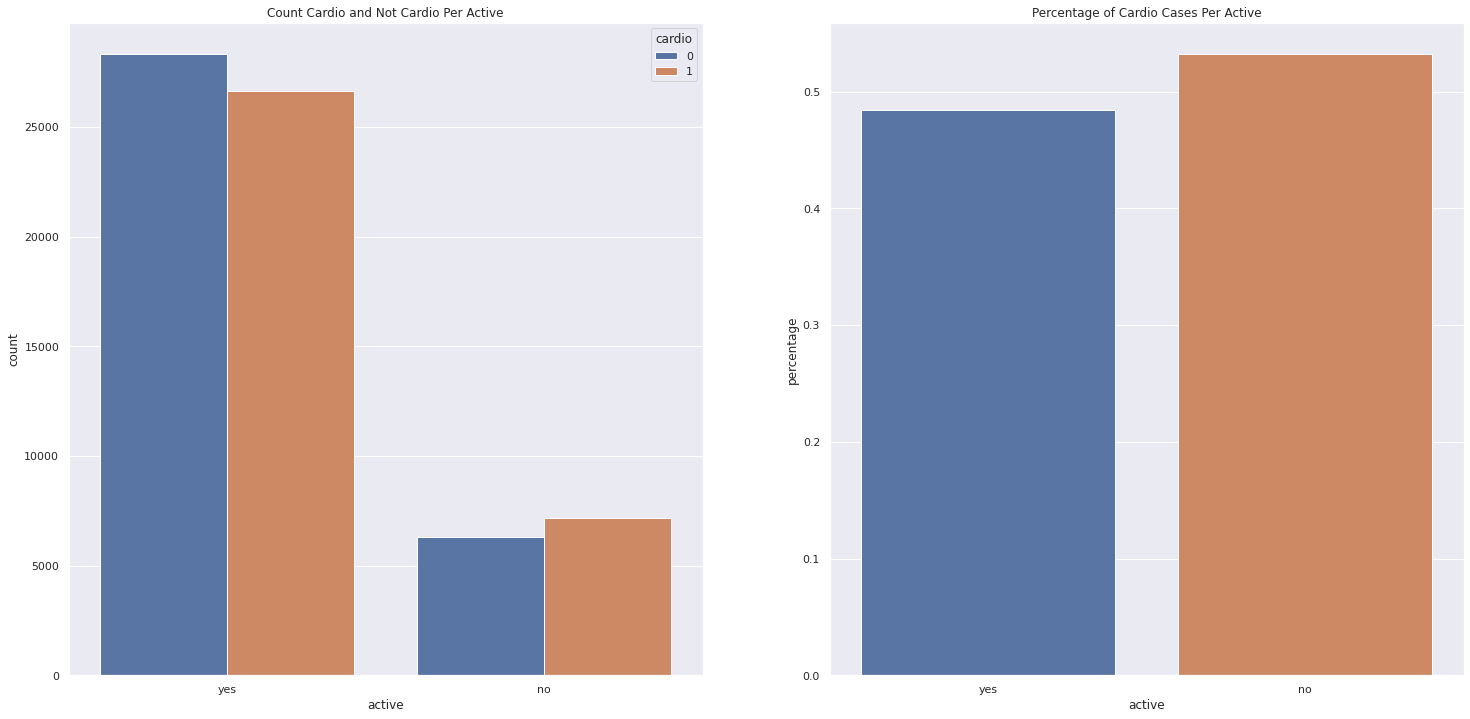

In [65]:
# plot countplot active x cardio
plt.subplot(1, 2, 1)
sns.countplot(x='active', hue='cardio', data=df5)
plt.title('Count Cardio and Not Cardio Per Active')

# plot barplot percentage x glucose
plt.subplot(1, 2, 2)
sns.barplot(y='percentage', x='active', data=aux3, order=['yes', 'no'])
plt.title('Percentage of Cardio Cases Per Active')

> The hypothesis is **True**

### H9. People who smoke are more likely to have cardiovascular diseases - FALSE

In [66]:
# create aux3 - percentage of cardio in smoke
# create aux1 and aux2 - count and sum
aux1 = df5[['smoke', 'cardio']].groupby('smoke').sum().reset_index()
aux2 = df5[['smoke', 'cardio']].groupby('smoke').count().reset_index()

# create aux3 - merge
aux3 = pd.merge(left=aux1, right=aux2, on='smoke')

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# final aux3
aux3 = aux3[['smoke', 'percentage']]

Text(0.5, 1.0, 'Percentage of Cardio and Not Cardio Per Smoke')

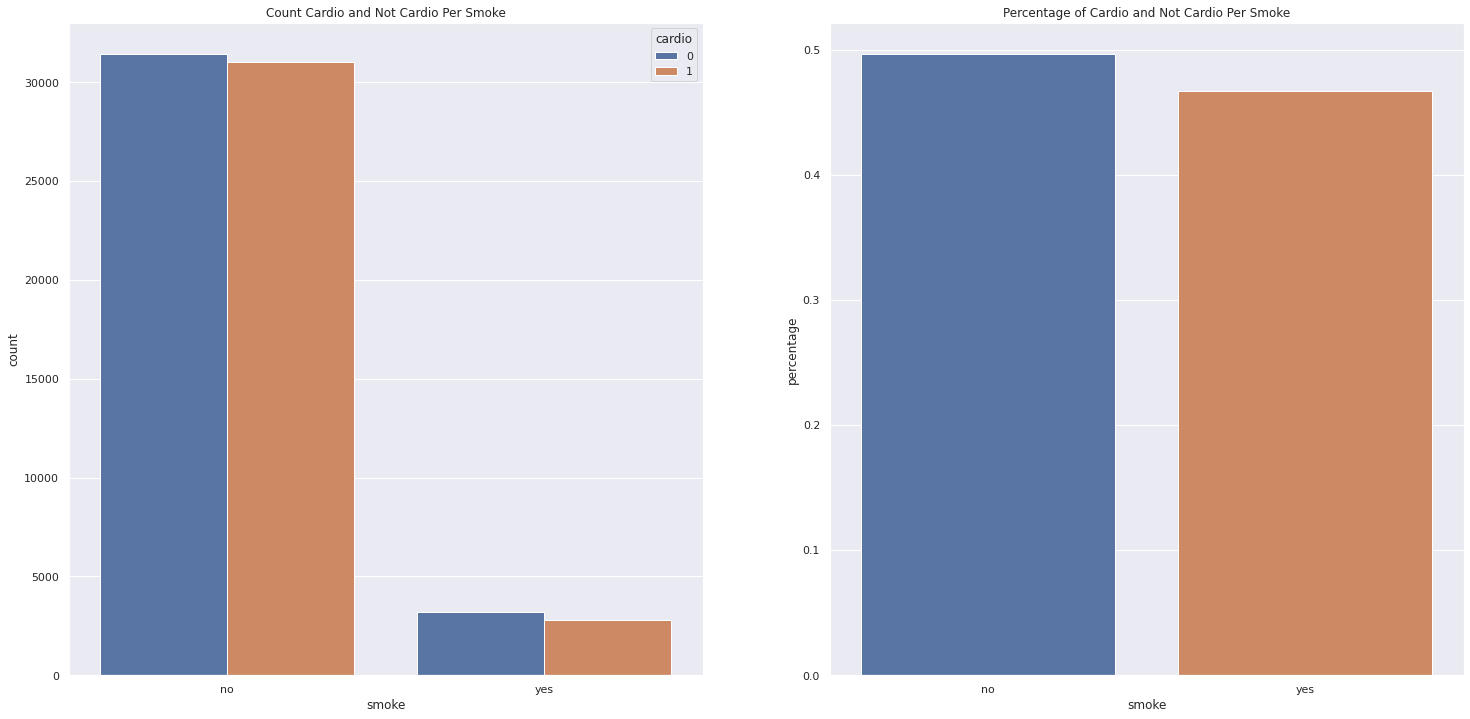

In [67]:
# plot countplot percentage x smoke
plt.subplot(1, 2, 1)
sns.countplot(x='smoke', hue='cardio', data=df5)
plt.title('Count Cardio and Not Cardio Per Smoke')

# plot barplot percentage x smoke
plt.subplot(1, 2, 2)
sns.barplot(y='percentage', x='smoke', data=aux3)
plt.title('Percentage of Cardio and Not Cardio Per Smoke')

> The hypothesis is **False**

### H10. People who consume alcohol are more likely to have cardiovascular diseases - FALSE

In [68]:
# create aux3 - percentage of cardio in alcohol
# create aux1 and aux2 - count and sum
aux1 = df5[['alcohol', 'cardio']].groupby('alcohol').sum().reset_index()
aux2 = df5[['alcohol', 'cardio']].groupby('alcohol').count().reset_index()

# create aux3 - merge
aux3 = pd.merge(left=aux1, right=aux2, on='alcohol')

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# final aux3
aux3 = aux3[['alcohol', 'percentage']]

Text(0.5, 1.0, 'Percentage of Cardio and Not Cardio Per Alcohol')

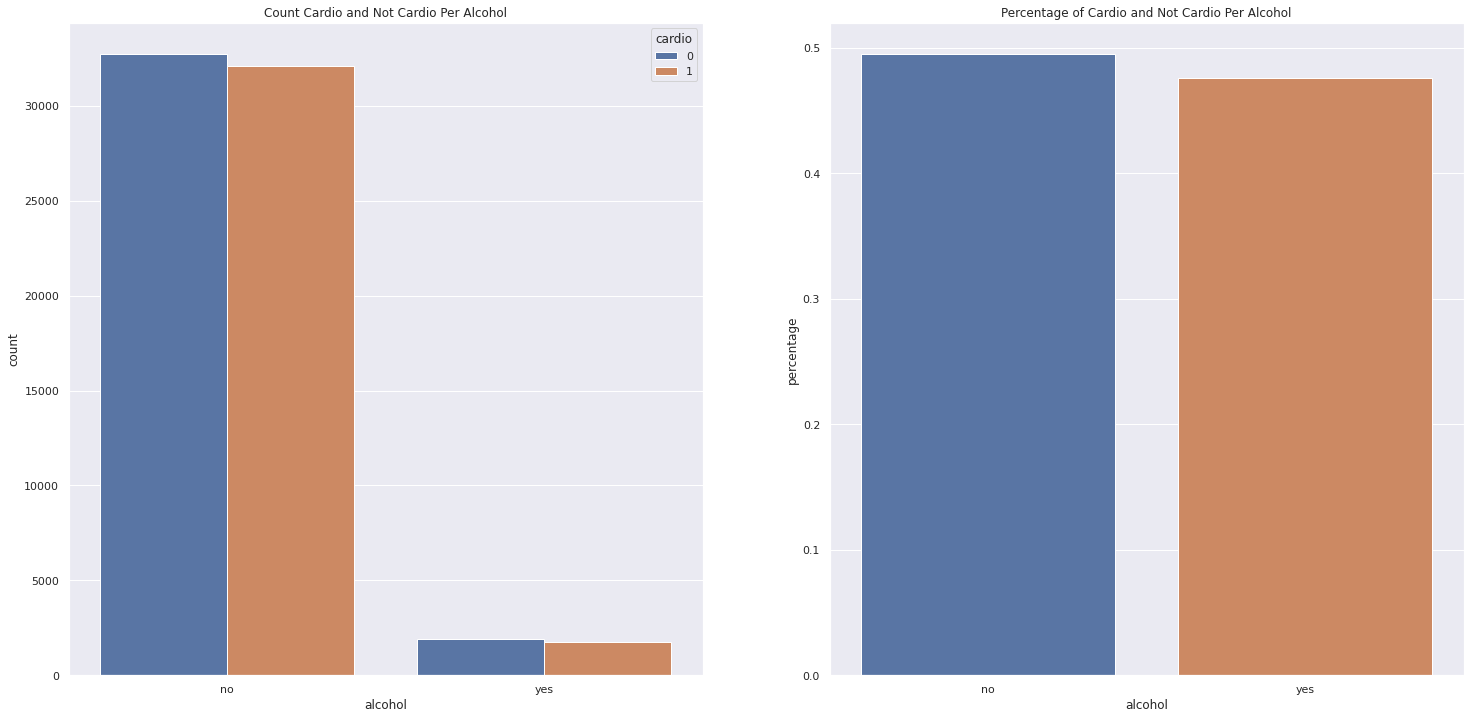

In [69]:
# plot countplot percentage x alcohol
plt.subplot(1, 2, 1)
sns.countplot(x='alcohol', hue='cardio', data=df5)
plt.title('Count Cardio and Not Cardio Per Alcohol')

# plot barplot percentage x alcohol
plt.subplot(1, 2, 2)
sns.barplot(y='percentage', x='alcohol', data=aux3)
plt.title('Percentage of Cardio and Not Cardio Per Alcohol')

> The hypothesis is **False**

### H11. People with high systolic pressure are more likely to have cardiovascular diseases - TRUE

In [70]:
# create p_systolic x cardio aux1 mean
aux1 = df5[['p_systolic', 'cardio']].groupby('cardio').mean().reset_index()

Text(0.5, 1.0, 'Average Value For Systolic Pressure per Cardio')

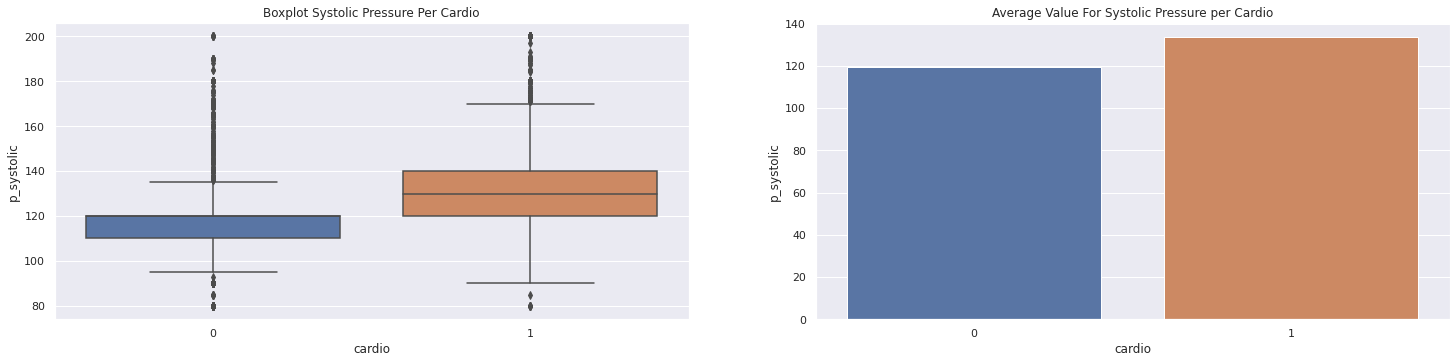

In [71]:
# plot boxplot p_systolic x cardio
plt.subplot(2, 2, 1)
sns.boxplot(y='p_systolic', x='cardio', data=df5)
plt.title('Boxplot Systolic Pressure Per Cardio')

# plot barplot p_systolic x cardio - mean
plt.subplot(2, 2, 2)
sns.barplot(x='cardio', y='p_systolic', data=aux1)
plt.title('Average Value For Systolic Pressure per Cardio')

> The hypothesis is **True**

### H12. People with high diastolic pressure are more likely to have cardiovascular diseases - TRUE

In [72]:
# create p_diastolic x cardio aux1 mean
aux1 = df5[['p_diastolic', 'cardio']].groupby('cardio').mean().reset_index()

Text(0.5, 1.0, 'Average Value For Diastolic Pressure per Cardio')

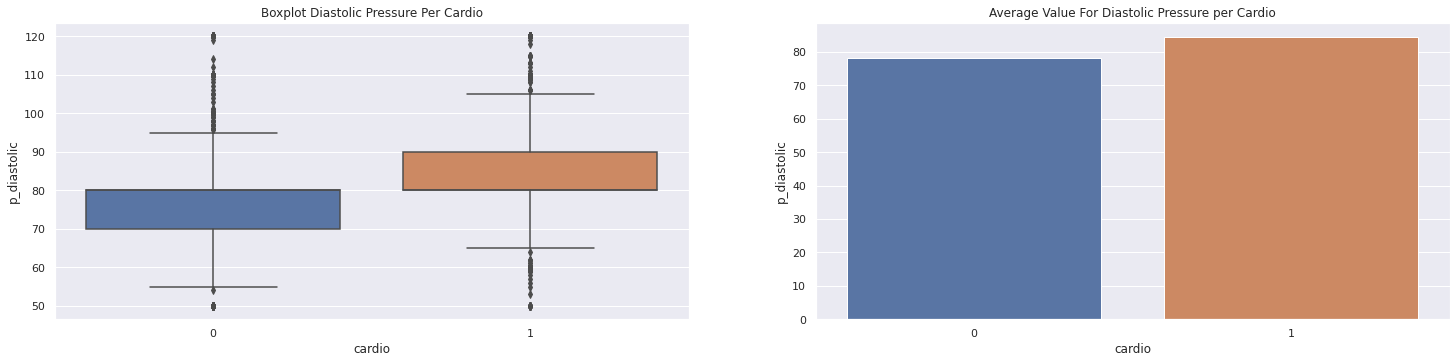

In [73]:
# plot boxplot p_diastolic x cardio
plt.subplot(2, 2, 1)
sns.boxplot(y='p_diastolic', x='cardio', data=df5)
plt.title('Boxplot Diastolic Pressure Per Cardio')

# plot barplot p_diastolic x cardio - mean
plt.subplot(2, 2, 2)
sns.barplot(x='cardio', y='p_diastolic', data=aux1)
plt.title('Average Value For Diastolic Pressure per Cardio')

> The hypothesis is **True**

### H13. People with greater difference between systolic and diastolic pressures are more likely to have cardiovascular diseases - TRUE

In [74]:
# create dif_pression x cardio aux1 mean
aux1 = df5[['dif_pressure', 'cardio']].groupby('cardio').mean().reset_index()

Text(0.5, 1.0, 'Average Value For Difference Pressure per Cardio')

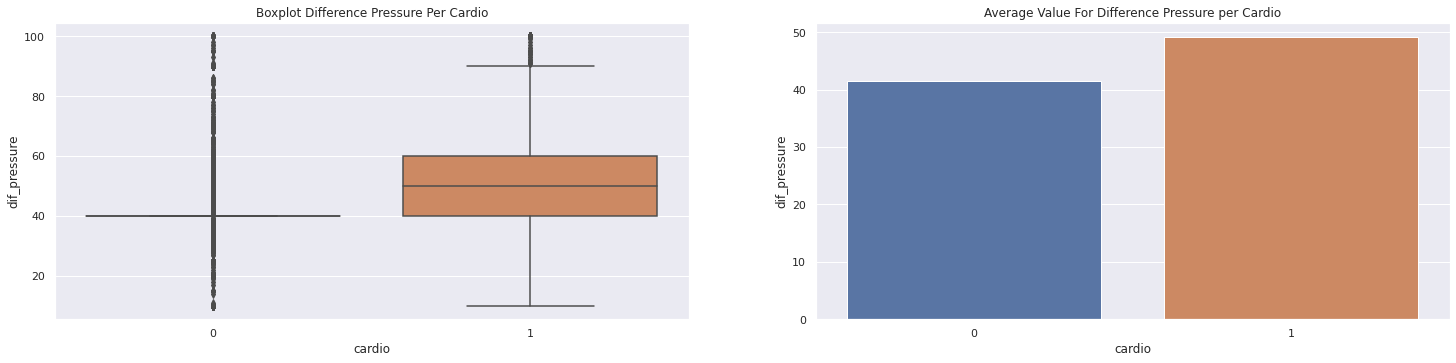

In [75]:
# plot boxplot difference pressure x cardio
plt.subplot(2, 2, 1)
sns.boxplot(x='cardio', y='dif_pressure', data=df5)
plt.title('Boxplot Difference Pressure Per Cardio')

# plot barplot difference pressure x cardio - mean
plt.subplot(2, 2, 2)
sns.barplot(x='cardio', y='dif_pressure', data=aux1)
plt.title('Average Value For Difference Pressure per Cardio')

> The hypothesis is **True**

### H14. People classified as having high blood pressure are more likely to have cardiovascular diseases - TRUE

In [76]:
# create aux3 - percentage of cardio in high_pressure
# create aux1 and aux2 - count and sum
aux1 = df5[['high_pressure', 'cardio']].groupby('high_pressure').sum().reset_index()
aux2 = df5[['high_pressure', 'cardio']].groupby('high_pressure').count().reset_index()

# create aux3 - merge
aux3 = pd.merge(left=aux1, right=aux2, on='high_pressure')

# percentage calculation
aux3['percentage'] = aux3['cardio_x'] / aux3['cardio_y']

# final aux3
aux3 = aux3[['high_pressure', 'percentage']]

Text(0.5, 1.0, 'Percentage of Cardio Cases Per High Pressure Value')

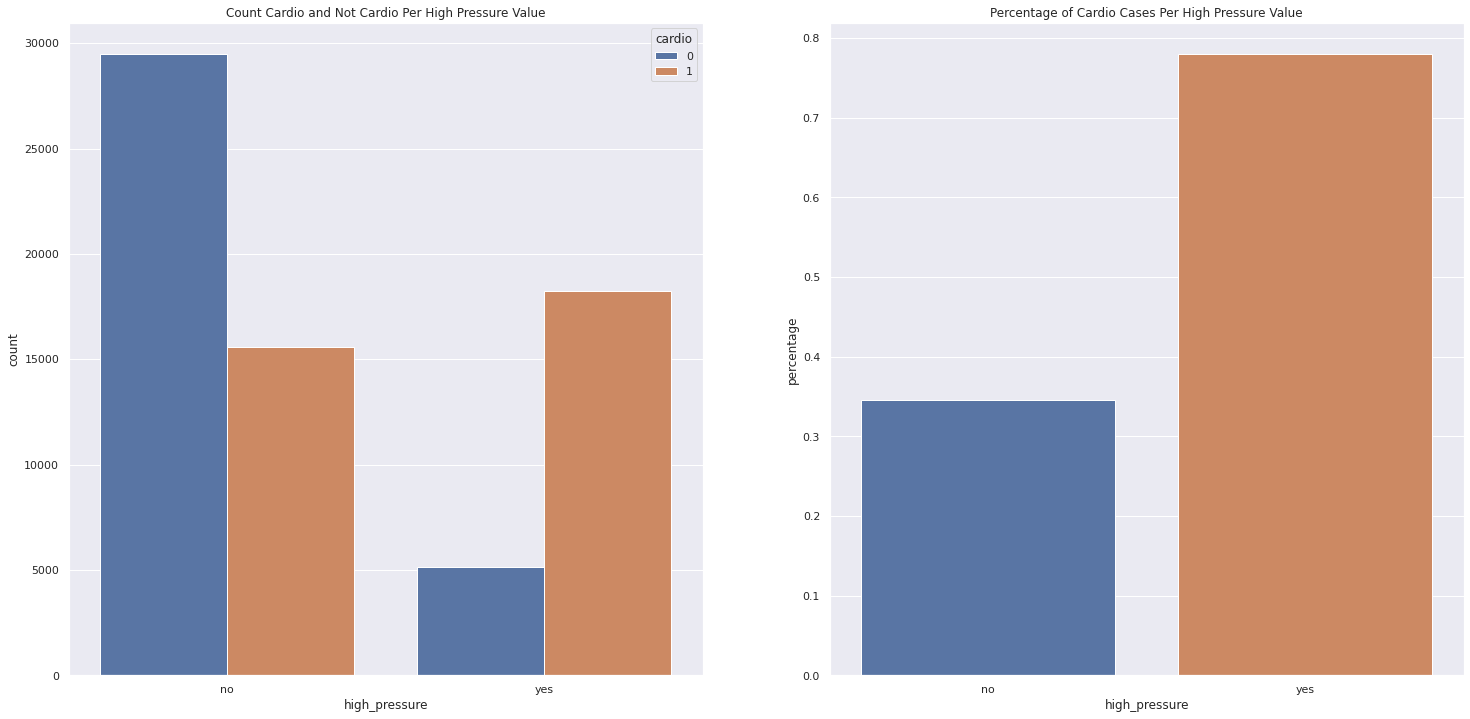

In [77]:
# plot countplot high_pressure x cardio
plt.subplot(1, 2, 1)
sns.countplot(x='high_pressure', hue='cardio', data=df5)
plt.title('Count Cardio and Not Cardio Per High Pressure Value')

# plot barplot percentage x high_pressure
plt.subplot(1, 2, 2)
sns.barplot(y='percentage', x='high_pressure', data=aux3)
plt.title('Percentage of Cardio Cases Per High Pressure Value')

> The hypothesis is **True**

## 5.3. Multivariate Analysis

In [78]:
num_attributes = df5.select_dtypes(include=['float64', 'int64'])
cat_attributes = df5.select_dtypes(exclude=['float64', 'int64'])

### 5.3.1. Numerical Attributes

<AxesSubplot:>

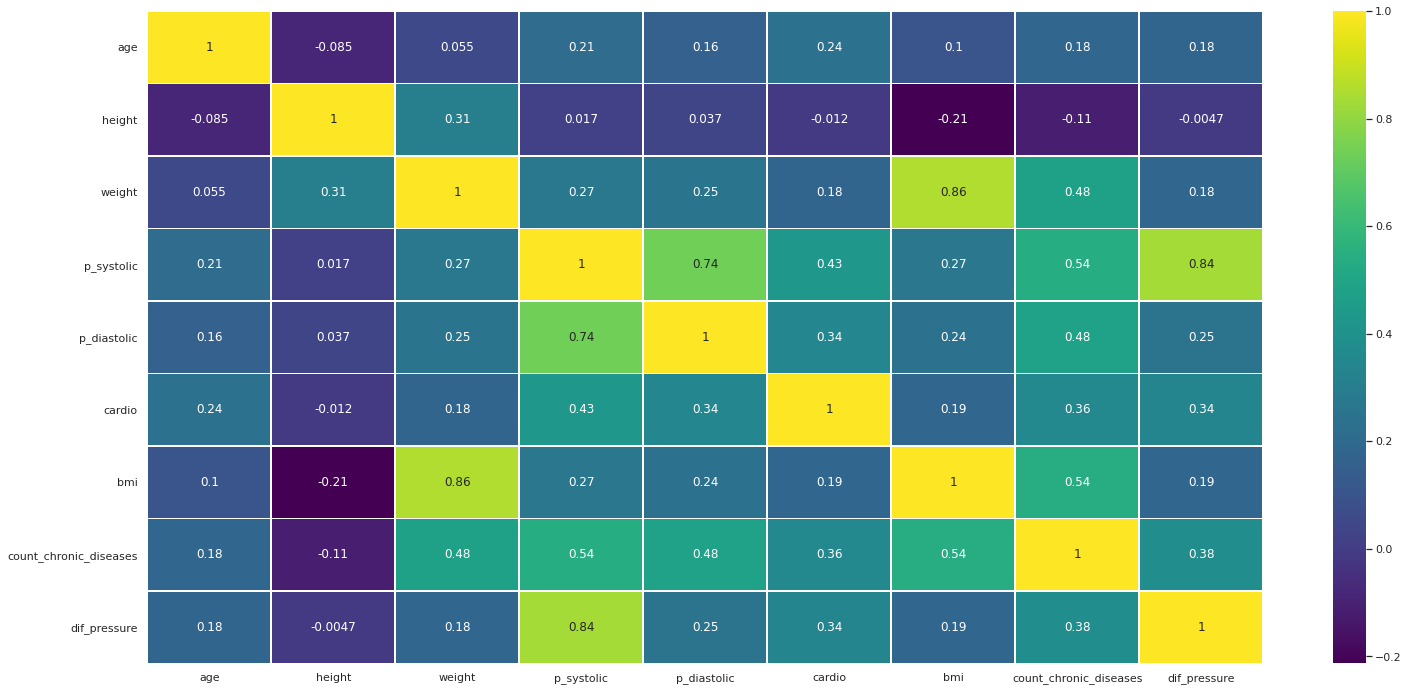

In [79]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, cmap='viridis', linewidths=.5, annot=True)

### 5.3.2. Categorical Attributes

<AxesSubplot:>

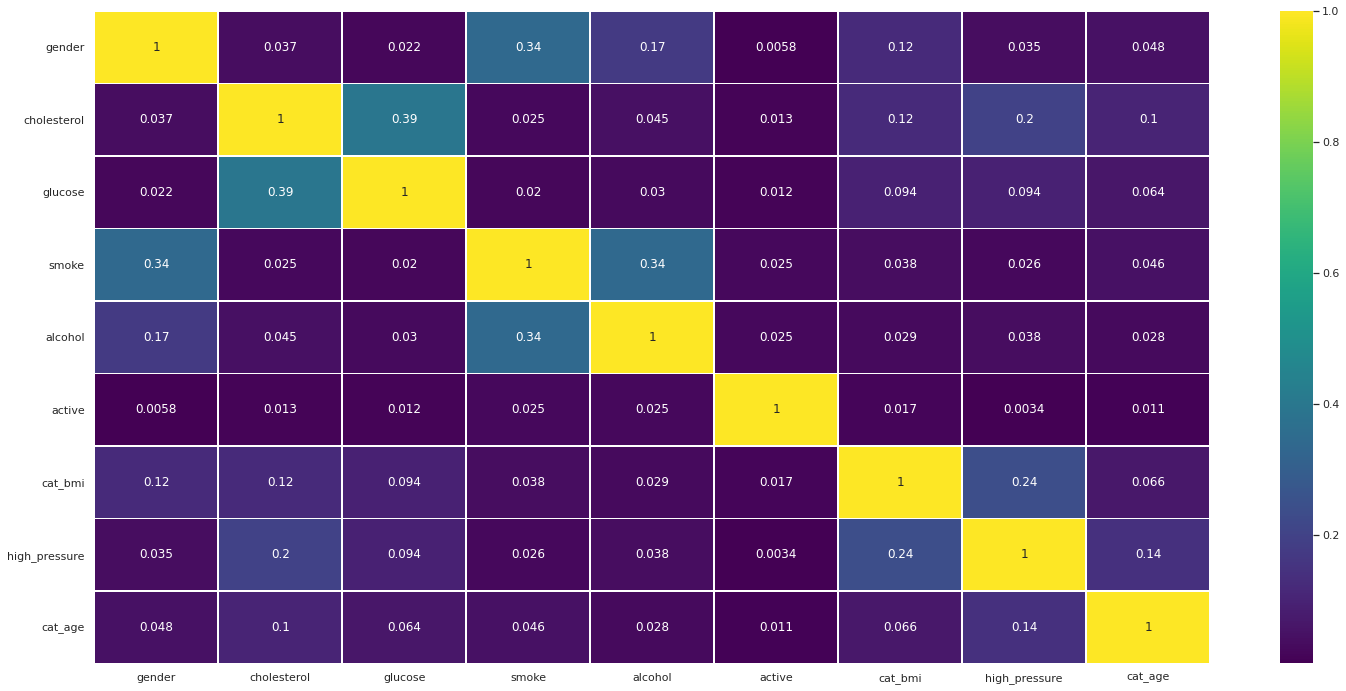

In [80]:
cat = {}

for value in cat_attributes.columns:
    cols = []
    for value_ in cat_attributes.columns:
        cols.append(cramer_v(cat_attributes[value], cat_attributes[value_]))
        
    cat[value] = cols
    
d = pd.DataFrame(cat)

d = d.set_index(d.columns)

# Plot
sns.heatmap(d, cmap='viridis', linewidths=.5, annot=True)

# 6.0. DATA PREPARATION

In [81]:
df6 = df4.copy()

In [82]:
df6.head()

,age,gender,height,weight,p_systolic,p_diastolic,cholesterol,glucose,smoke,alcohol,active,cardio,bmi,cat_bmi,high_pressure,count_chronic_diseases,dif_pressure,cat_age
0,50,woman,168,62.0,110,80,normal,normal,0,0,1,0,21.967120,normal,0,0,30,50 - 59
1,55,man,156,85.0,140,90,well_above_normal,normal,0,0,1,1,34.927679,obese,1,3,50,50 - 59
2,52,man,165,64.0,130,70,well_above_normal,normal,0,0,0,1,23.507805,normal,0,1,60,50 - 59
3,48,woman,169,82.0,150,100,normal,normal,0,0,1,1,28.710479,overwight,1,1,50,39 - 49
4,48,man,156,56.0,100,60,normal,normal,0,0,0,0,23.011177,normal,0,0,40,39 - 49


## 6.1. Split Dataset

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X = df6.drop('cardio', axis=1)
y = df6.loc[:, 'cardio']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [86]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## 6.2. Scalling Dataset

### 6.2.1. Ploting Distribution

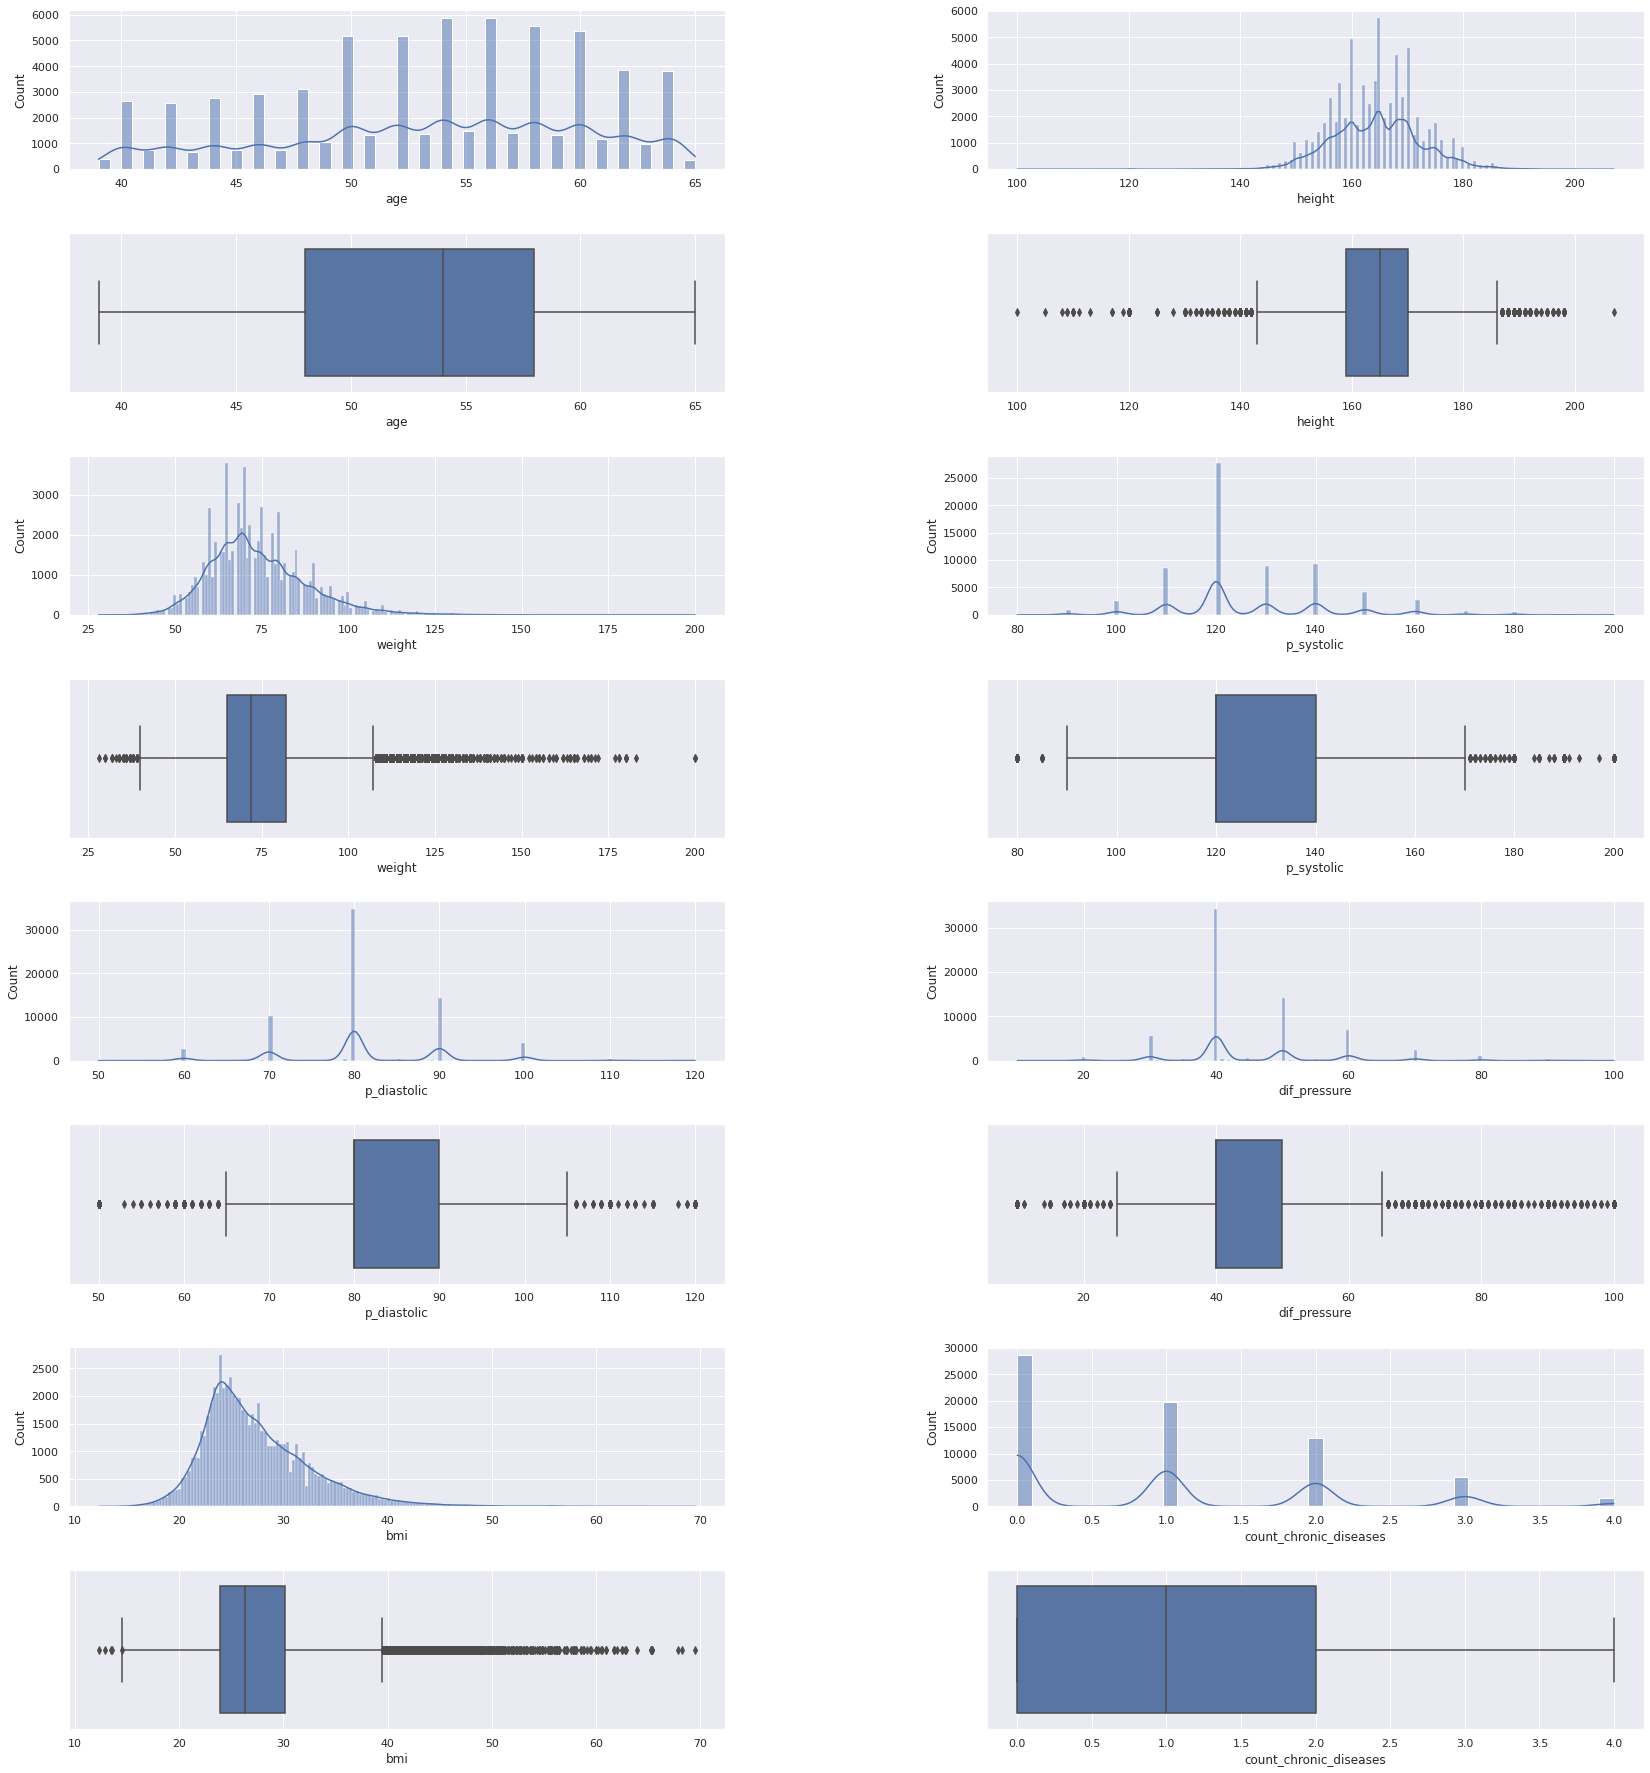

In [87]:
# age
plt.subplot(8, 2, 1)
sns.histplot(df6['age'], kde=True)

plt.subplot(8, 2, 3)
sns.boxplot(x = df6['age'])

# height
plt.subplot(8, 2, 2)
sns.histplot(df6['height'], kde=True)

plt.subplot(8, 2, 4)
sns.boxplot(x = df6['height'])

# weight
plt.subplot(8, 2, 5)
sns.histplot(df6['weight'], kde=True)

plt.subplot(8, 2, 7)
sns.boxplot(x = df6['weight'])

# p_systolic
plt.subplot(8, 2, 6)
sns.histplot(df6['p_systolic'], kde=True)

plt.subplot(8, 2, 8)
sns.boxplot(x = df6['p_systolic'])

# p_diastolic
plt.subplot(8, 2, 9)
sns.histplot(df6['p_diastolic'], kde=True)

plt.subplot(8, 2, 11)
sns.boxplot(x = df6['p_diastolic'])

# dif_pressure
plt.subplot(8, 2, 10)
sns.histplot(df6['dif_pressure'], kde=True)

plt.subplot(8, 2, 12)
sns.boxplot(x = df6['dif_pressure'])

# bmi
plt.subplot(8, 2, 13)
sns.histplot(df6['bmi'], kde=True)

plt.subplot(8, 2, 15)
sns.boxplot(x = df6['bmi'])

# bmi
plt.subplot(8, 2, 14)
sns.histplot(df6['count_chronic_diseases'], kde=True)

plt.subplot(8, 2, 16)
sns.boxplot(x = df6['count_chronic_diseases'])

# plot adjusts
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.40)

### 6.2.2. Scalling

In [88]:
mms = MinMaxScaler()
rs = RobustScaler()
ss = StandardScaler()

In [89]:
# age -> MinMaxScaler
X_train['age'] = mms.fit_transform(X_train[['age']].values)
X_test['age'] = mms.fit_transform(X_test[['age']].values)

# weight -> RobustScaler
X_train['weight'] = rs.fit_transform(X_train[['weight']].values)
X_test['weight'] = rs.fit_transform(X_test[['weight']].values)

# height -> RobustScaler
X_train['height'] = rs.fit_transform(X_train[['height']].values)
X_test['height'] = rs.fit_transform(X_test[['height']].values)

# p_systolic -> RobustScaler
X_train['p_systolic'] = rs.fit_transform(X_train[['p_systolic']].values)
X_test['p_systolic'] = rs.fit_transform(X_test[['p_systolic']].values)

# p_diastolic -> RobustScaler
X_train['p_diastolic'] = rs.fit_transform(X_train[['p_diastolic']].values)
X_test['p_diastolic'] = rs.fit_transform(X_test[['p_diastolic']].values)

# dif_pressure -> RobustScaler
X_train['dif_pressure'] = rs.fit_transform(X_train[['dif_pressure']].values)
X_test['dif_pressure'] = rs.fit_transform(X_test[['dif_pressure']].values)

# bmi -> RobustScaler
X_train['bmi'] = rs.fit_transform(X_train[['bmi']].values)
X_test['bmi'] = rs.fit_transform(X_test[['bmi']].values)

# bmi -> RobustScaler
X_train['count_chronic_diseases'] = ss.fit_transform(X_train[['count_chronic_diseases']].values)
X_test['count_chronic_diseases'] = ss.fit_transform(X_test[['count_chronic_diseases']].values)

In [90]:
X_train.head()

,age,gender,height,weight,p_systolic,p_diastolic,cholesterol,glucose,smoke,alcohol,active,bmi,cat_bmi,high_pressure,count_chronic_diseases,dif_pressure,cat_age
0,0.192308,man,-0.363636,-0.882353,-1.0,-2.0,normal,normal,0,0,1,-0.700757,normal,0,-0.938064,0.0,39 - 49
1,0.538462,man,-1.363636,-0.705882,0.0,0.0,normal,normal,0,0,1,0.048214,overwight,0,-0.938064,0.0,50 - 59
2,0.653846,man,-1.818182,0.764706,0.5,0.0,above_normal,normal,0,0,1,2.252061,extremely obese,0,0.935704,1.0,50 - 59
3,0.384615,woman,1.818182,2.529412,0.5,1.0,above_normal,normal,1,1,1,1.158755,obese,1,1.872588,0.0,39 - 49
4,0.615385,man,0.090909,-0.058824,0.0,-1.0,normal,normal,0,0,1,-0.096071,overwight,0,-0.938064,1.0,50 - 59


## 6.3. Encoding Dataset

In [91]:
# cholesterol -> ordinal encoding
cholesterol_dict = {'normal': 1, 'above_normal': 2, 'well_above_normal': 3}
X_train['cholesterol'] = X_train['cholesterol'].map(cholesterol_dict)
X_test['cholesterol'] = X_test['cholesterol'].map(cholesterol_dict)

# glucose -> ordinal encoding
glucose_dict = {'normal': 1, 'above_normal': 2, 'well_above_normal': 3}
X_train['glucose'] = X_train['glucose'].map(glucose_dict)
X_test['glucose'] = X_test['glucose'].map(glucose_dict)

# cat_bmi -> ordinal encoding
cat_bmi_dict = {'thiness': 1, 'normal': 2, 'overwight': 3, 'obese': 4, 'extremely obese': 5 }
X_train['cat_bmi'] = X_train['cat_bmi'].map(cat_bmi_dict)
X_test['cat_bmi'] = X_test['cat_bmi'].map(cat_bmi_dict)

# cat_age -> ordinal encoding
cat_age_dict = {'39 - 49': 1, '50 - 59': 2, '60 - 65': 3}
X_train['cat_age'] = X_train['cat_age'].map(cat_age_dict)
X_test['cat_age'] = X_test['cat_age'].map(cat_age_dict)

# gender -> ohe
X_train = pd.get_dummies(X_train, prefix='gender', columns=['gender'], drop_first=True)
X_test = pd.get_dummies(X_test, prefix='gender', columns=['gender'], drop_first=True)

In [92]:
X_train.head()

,age,height,weight,p_systolic,p_diastolic,cholesterol,glucose,smoke,alcohol,active,bmi,cat_bmi,high_pressure,count_chronic_diseases,dif_pressure,cat_age,gender_woman
0,0.192308,-0.363636,-0.882353,-1.0,-2.0,1,1,0,0,1,-0.700757,2,0,-0.938064,0.0,1,0
1,0.538462,-1.363636,-0.705882,0.0,0.0,1,1,0,0,1,0.048214,3,0,-0.938064,0.0,2,0
2,0.653846,-1.818182,0.764706,0.5,0.0,2,1,0,0,1,2.252061,5,0,0.935704,1.0,2,0
3,0.384615,1.818182,2.529412,0.5,1.0,2,1,1,1,1,1.158755,4,1,1.872588,0.0,1,1
4,0.615385,0.090909,-0.058824,0.0,-1.0,1,1,0,0,1,-0.096071,3,0,-0.938064,1.0,2,0


# 7.0. FEATURE SELECTION

In [93]:
df7 = df6.copy()

## 7.1. Boruta as Feature Selector

In [94]:
X_train_nn = X_train.values
y_train_nn = y_train.values.ravel()

### 7.1.1. Boruta with ExtraTreeSclassfier

In [95]:
#etc = ExtraTreesClassifier(n_jobs=-1)

#boruta_etc = BorutaPy(etc, n_estimators='auto', verbose=2, random_state=32).fit(X_train_nn, y_train_nn)

In [96]:
#cols_selected_etc = boruta_etc.support_.tolist()

In [97]:
#cols_selected_boruta_etc = X_train.iloc[:, cols_selected_etc].columns.to_list()
#cols_selected_boruta_etc

### 7.1.2. Boruta with RandomForestRegressor

In [98]:
#rf = RandomForestRegressor(n_jobs=-1)

#boruta_rf = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=32).fit(X_train_nn, y_train_nn)

In [99]:
#cols_selected_rf = boruta_rf.support_.tolist()

In [100]:
#cols_selected_boruta_rf = X_train.iloc[:, cols_selected_rf].columns.to_list()
#cols_selected_boruta_rf

### 7.1.3. Boruta with XGBoost

In [101]:
#xg = xgb.XGBRegressor()

#boruta_xgb = BorutaPy(xg, n_estimators='auto', verbose=2, random_state=32).fit(X_train_nn, y_train_nn)

In [102]:
#cols_selected_xgb = boruta_xgb.support_.tolist()

In [103]:
#cols_selected_boruta_xgb = X_train.iloc[:, cols_selected_xgb].columns.to_list()
#cols_selected_boruta_xgb

## 7.2. Manual Feature Selection

<AxesSubplot:>

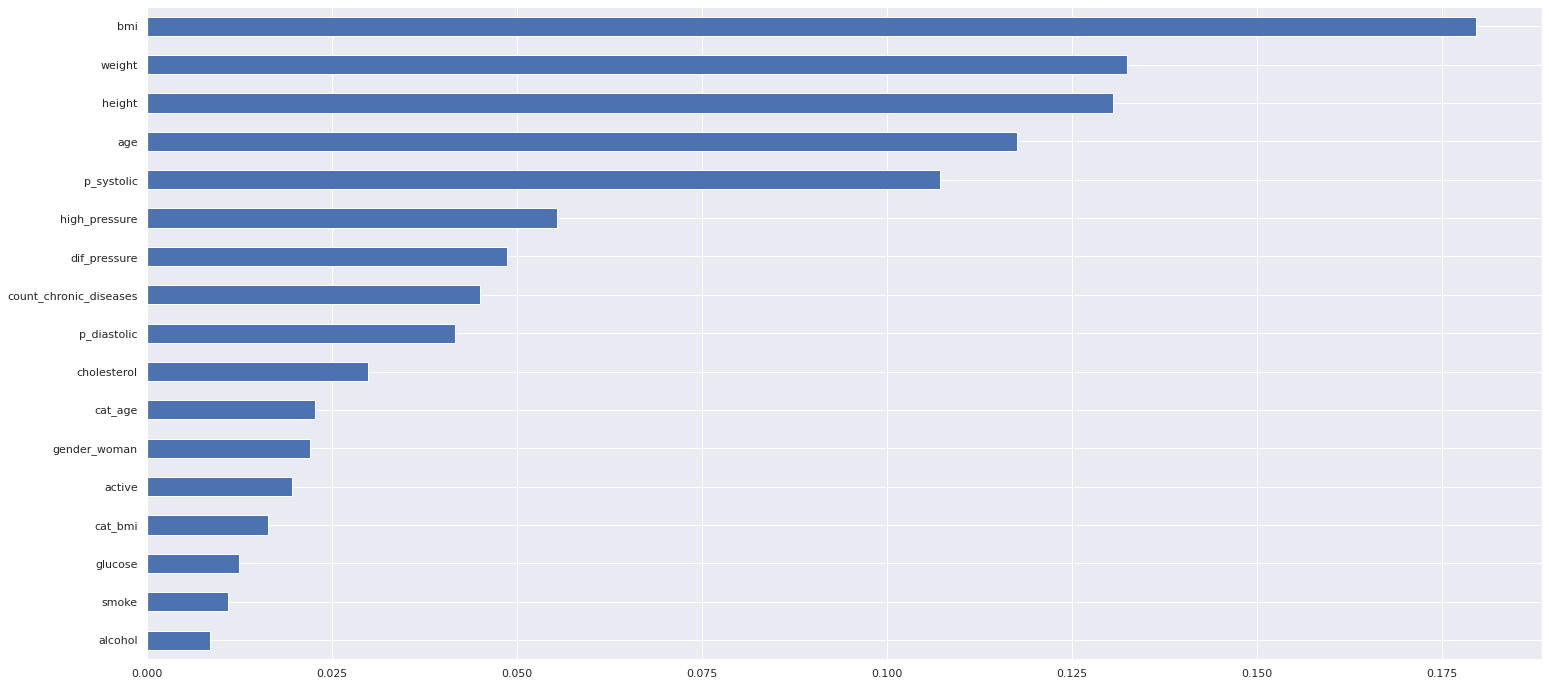

In [104]:
#feature importances 
rf_model = RandomForestClassifier(n_jobs = -1)
rf_model.fit(X_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')

## 7.3. Final List Features

In [105]:
list_features = ['age', 'p_systolic', 'bmi', 'dif_pressure',
                 'cholesterol', 'glucose', 'p_diastolic', 
                 'count_chronic_diseases']

# 8.0. MACHINE LEARNING MODELLING

In [106]:
X_train = X_train[list_features]
X_test = X_test[list_features]

## 8.1. Baseline Model

## 8.2. Logistic Regressor

### 8.2.1. Model

In [107]:
# define model
logreg = LogisticRegression(random_state=32)

# training model
logreg.fit(X_train.values, y_train.values.ravel())

# predicts
yhat_log = logreg.predict(X_test)

In [108]:
# predictions
logreg_cv = cross_val_predict(logreg, X_train, y_train, cv=5)
logreg_roc = roc_auc_score(y_train, logreg_cv)

#performance
result_log = pd.DataFrame(["Logistic Regression",accuracy_score(y_test,yhat_log),cohen_kappa_score(y_test,yhat_log),
                          recall_score(y_test,yhat_log), f1_score(y_test,yhat_log),
                          precision_score(y_test,yhat_log), logreg_roc]).T

result_log.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

In [109]:
result_log

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score,roc_auc_score
0,Logistic Regression,0.723143,0.446249,0.656291,0.703202,0.757336,0.725084


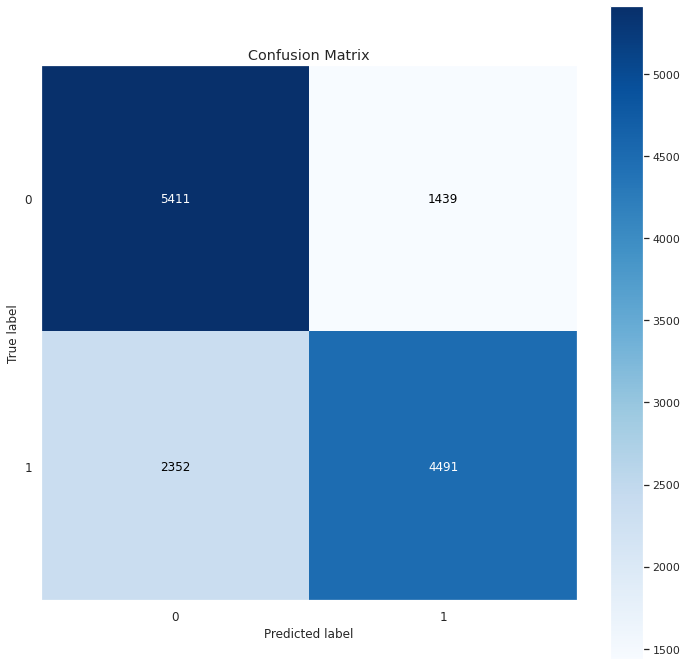

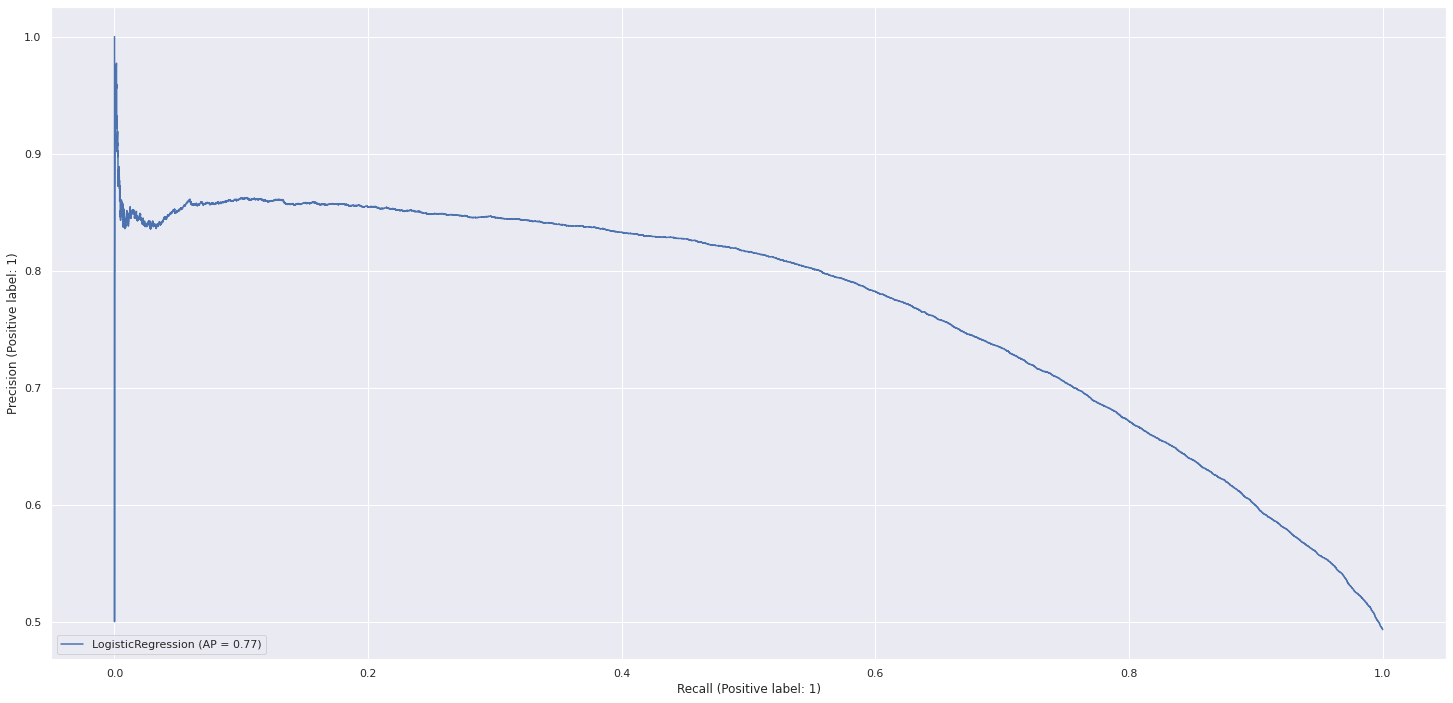

In [110]:
# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_log, normalize = False, figsize=(12, 12))


#precision_recall_curve
plot_precision_recall_curve(logreg, X_train, y_train)

### 8.2.1. Cross-Validation

In [111]:
#cross validation scores
log_cv = cross_val_score(logreg,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(log_cv),4),np.round(np.std(log_cv),4)))

Average: 0.7261 +/- Std 0.0074


## 8.3. KNN

### 8.3.1. Model

In [112]:
# define model
knn = KNeighborsClassifier()

# training model
knn.fit(X_train.values, y_train.values.ravel())

# predicts
yhat_knn = knn.predict(X_test)

In [113]:
# AUC-ROC
knn_cv = cross_val_predict(knn, X_train, y_train, cv=5)
knn_roc = roc_auc_score(y_train, knn_cv)

#performance
result_knn = pd.DataFrame(["KNN",accuracy_score(y_test,yhat_knn),cohen_kappa_score(y_test,yhat_knn),
                          recall_score(y_test,yhat_knn), f1_score(y_test,yhat_knn),
                           precision_score(y_test,yhat_knn), knn_roc]).T

result_knn.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

In [114]:
result_knn

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score,roc_auc_score
0,KNN,0.686847,0.373683,0.668566,0.680905,0.693707,0.693538


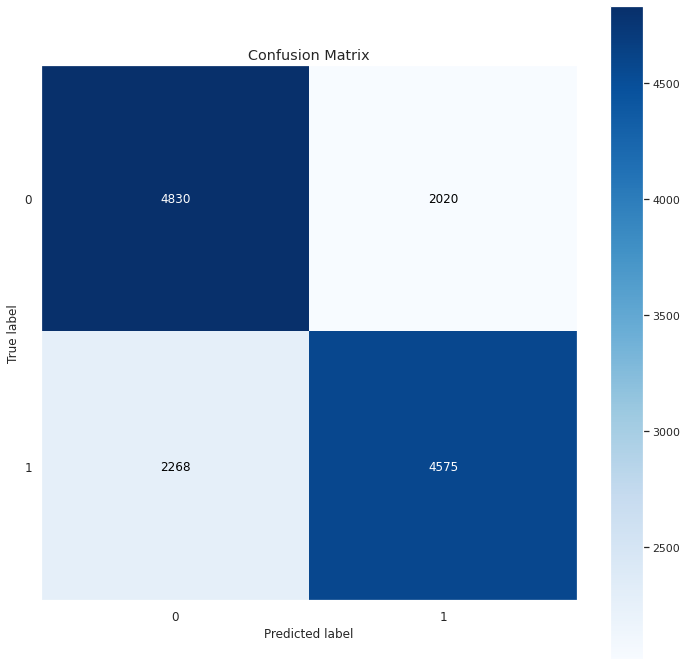

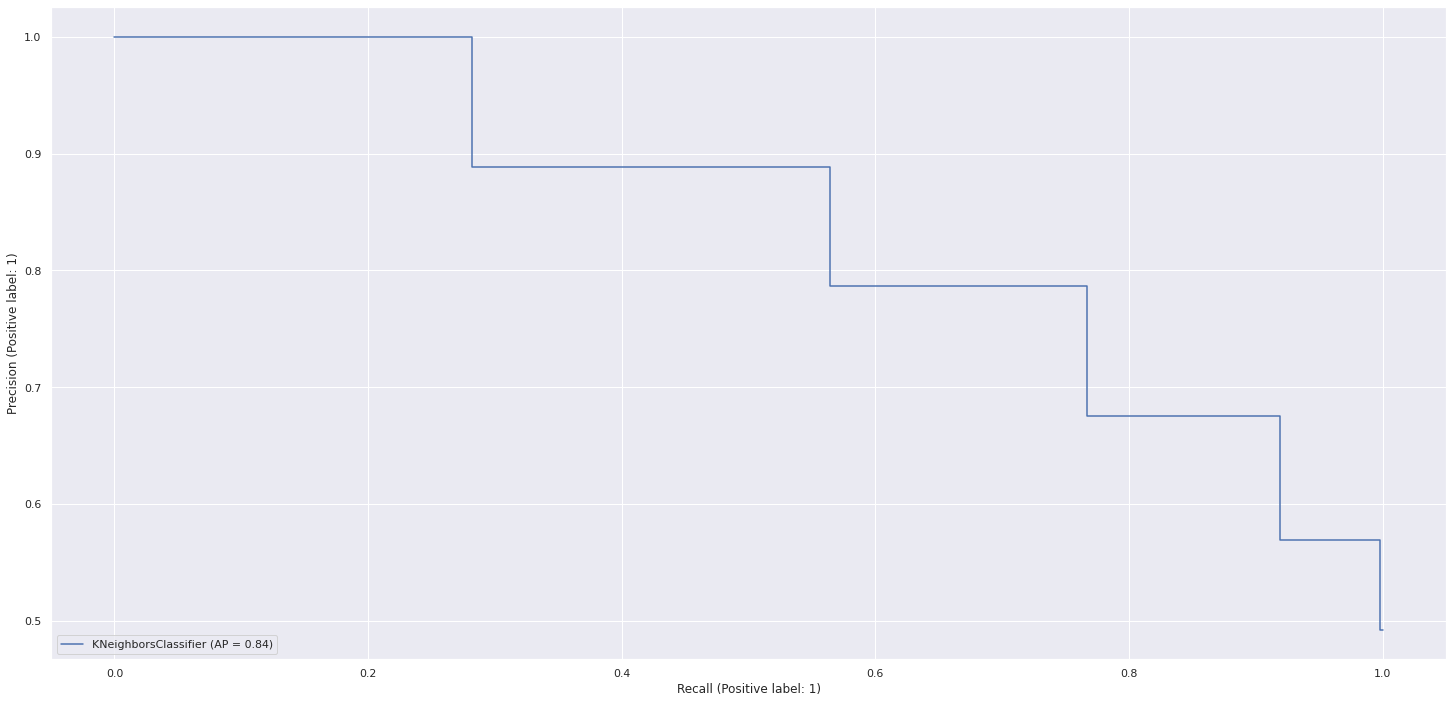

In [115]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_knn, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(knn, X_train, y_train)

### 8.3.2. Cross Validation

In [116]:
#cross validation scores
knn_cv = cross_val_score(knn, X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(knn_cv),4),np.round(np.std(knn_cv),4)))

Average: 0.6944 +/- Std 0.0056


## 8.4. SVM

### 8.4.1. Model

In [117]:
# define model
svm = SVC(random_state=32)

# training model
svm.fit(X_train.values, y_train.values.ravel())

# predicts
yhat_svm = svm.predict(X_test)

In [118]:
# AUC-ROC
svm_cv = cross_val_predict(svm, X_train, y_train, cv=5)
svm_roc = roc_auc_score(y_train, svm_cv)

# performance 
result_svm = pd.DataFrame(['SVM', accuracy_score(y_test, yhat_svm), cohen_kappa_score(y_test, yhat_svm),
                            recall_score(y_test, yhat_svm), f1_score(y_test, yhat_svm), 
                            precision_score(y_test, yhat_svm), svm_roc]).T

result_svm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

In [119]:
result_svm

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score,roc_auc_score
0,SVM,0.718396,0.436737,0.621219,0.687975,0.770807,0.725297


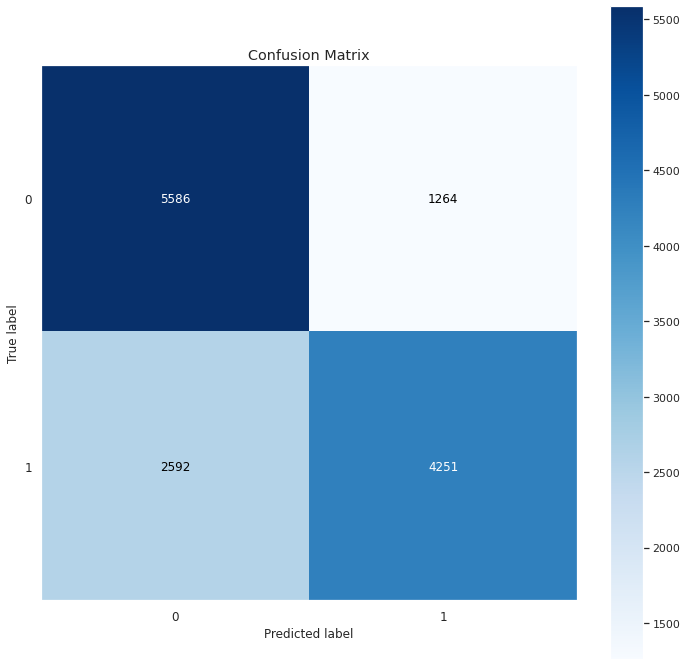

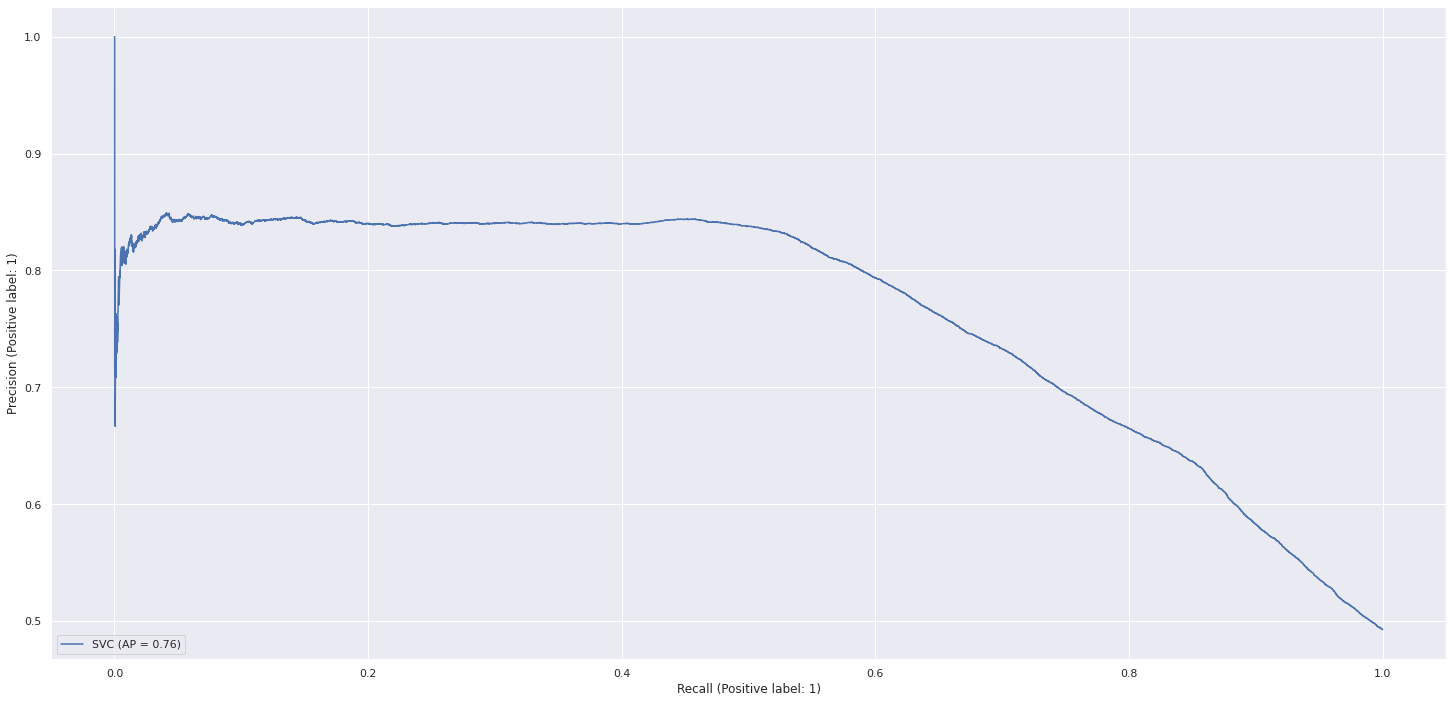

In [120]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_svm, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(svm, X_train, y_train)

### 8.4.2. Cross-Validation

In [ ]:
#cross validation scores
svm_cv = cross_val_score(svm, X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(svm_cv),4),np.round(np.std(svm_cv),4)))

## 8.5. GaussianNB

### 8.5.1. Model

In [ ]:
# define moddel
gnb = GaussianNB()

# train model
gnb.fit(X_train.values, y_train.values.ravel())

# predicts
yhat_gnb = gnb.predict(X_test)

In [ ]:
# AUC-ROC
gnb_cv = cross_val_predict(gnb, X_train, y_train, cv=5)
gnb_roc = roc_auc_score(y_train, gnb_cv)

#performance
result_gnb = pd.DataFrame(["GaussianNB",accuracy_score(y_test,yhat_gnb),cohen_kappa_score(y_test,yhat_gnb),
                          recall_score(y_test,yhat_gnb), f1_score(y_test,yhat_gnb),
                           precision_score(y_test,yhat_gnb), gnb_roc]).T

result_gnb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

In [ ]:
result_gnb

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_gnb, normalize = False, figsize=(12, 12))


#precision_recall_curve
plot_precision_recall_curve(gnb, X_train, y_train)

### 8.5.2. Cross-Validation

In [ ]:
#cross validation scores
gnb_cv = cross_val_score(gnb, X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(svm_cv),4),np.round(np.std(svm_cv),4)))

## 8.6. LGBM

### 8.6.1. Model

In [ ]:
# define model
lgbm_clf = LGBMClassifier()

# train model
lgbm_clf.fit(X_train.values, y_train.values.ravel())

# predictions
yhat_lgbm_clf = lgbm_clf.predict(X_test)

In [ ]:
# AUC-ROC
lgbm_clf_cv = cross_val_predict(lgbm_clf, X_train, y_train, cv=5)
lgbm_clf_roc = roc_auc_score(y_train, lgbm_clf_cv)

#performance
result_lgbm_clf = pd.DataFrame(["LGBMClassifer",accuracy_score(y_test,yhat_lgbm_clf),cohen_kappa_score(y_test,yhat_lgbm_clf),
                          recall_score(y_test,yhat_lgbm_clf), f1_score(y_test,yhat_lgbm_clf),
                           precision_score(y_test,yhat_lgbm_clf), gnb_roc]).T

result_lgbm_clf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

In [ ]:
result_lgbm_clf

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm_clf, normalize = False, figsize=(12, 12))


#precision_recall_curve
plot_precision_recall_curve(lgbm_clf, X_train, y_train)

### 8.6.2. Cross Validation

In [ ]:
#cross validation scores
gnb_cv = cross_val_score(lgbm_clf, X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(svm_cv),4),np.round(np.std(svm_cv),4)))

## 8.7. Random Forest

### 8.7.1. Model

In [ ]:
# define model
rf = RandomForestClassifier(n_jobs = -1)

# train model
rf.fit(X_train.values, y_train.values.ravel())

# predictions
yhat_rf = rf.predict(X_test)

In [ ]:
# AUC-ROC
rf_cv = cross_val_predict(rf, X_train, y_train, cv=5)
rf_roc = roc_auc_score(y_train, rf_cv)

#performance
result_rf = pd.DataFrame(["Random Forest",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),
                           precision_score(y_test,yhat_rf), rf_roc]).T

result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

In [ ]:
result_rf

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_rf, normalize = False, figsize=(12, 12))


#precision_recall_curve
plot_precision_recall_curve(rf, X_train, y_train)

### 8.7.2. Cross-Validation

In [ ]:
# cross validation scores
rf_cv = cross_val_score(rf, X_train, y_train.ravel(), cv=10, n_jobs=-1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),4)))

## 8.8. XGBoost

### 8.8.1. Model

In [ ]:
# define model
xgb_clf = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', use_label_encoder=False)

# train model
xgb_clf.fit(X_train.values, y_train.values.ravel())

# prediction
yhat_xgb = xgb_clf.predict(X_test.values)

In [ ]:
# AUC-ROC
xgb_cv = cross_val_predict(xgb_clf, X_train, y_train, cv=5)
xgb_clf_roc = roc_auc_score(y_train, xgb_cv)

#performance
result_xgb = pd.DataFrame(["XGBoostClassifier",accuracy_score(y_test,yhat_xgb),cohen_kappa_score(y_test,yhat_xgb),
                          recall_score(y_test,yhat_xgb), f1_score(y_test,yhat_xgb),
                           precision_score(y_test,yhat_xgb), xgb_clf_roc]).T

result_xgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

In [ ]:
result_xgb

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_xgb, normalize = False, figsize=(12, 12))


#precision_recall_curve
plot_precision_recall_curve(xgb_clf, X_train, y_train)

### 8.8.2. Cross Validation

In [ ]:
# cross validation scores
xgb_cv = cross_val_score(xgb_clf, X_train, y_train.ravel(), cv=10, n_jobs=-1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(xgb_cv),4),np.round(np.std(xgb_cv),4)))

## 8.9. Performance

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
df_tot = pd.concat([result_log, result_knn, result_svm, result_gnb,
                    result_lgbm_clf, result_rf, result_xgb]).sort_values(by='Accuracy', ascending=False)
df_tot

In [ ]:
def plot_roc_curve(models, X_test, y_test):
    
    for value in models:
        probs = value.predict_proba(X_test)
        preds = probs[:,1]

        fpr, tpr, thresholds = roc_curve(y_test, preds)    
        plt.plot(fpr, tpr, linewidth=2, label=str(value).split('(')[0])
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [ ]:
plot_roc_curve(models = [logreg, knn, gnb, rf, lgbm_clf, xgb_clf], X_test = X_test, y_test = y_test)

# 9.0. HYPERPAREMETER FINE TUNNING